# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [21]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import time
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# LOADING THE DATASET

While Loading the data below we can see that columns 18 and 19 have mixed datatypes, lets check it out and rectify it

In [ ]:
# load in the data
zf = zipfile.ZipFile('Udacity_capstone/udacity_capstone_dataset.zip') 
azdias = pd.read_csv(zf.open('Udacity_AZDIAS_052018.csv'), sep=';')
customers = pd.read_csv(zf.open('Udacity_CUSTOMERS_052018.csv'), sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
pre_filtered_nan = [azdias.isna().sum().sum(),customers.isna().sum().sum()]
print(pre_filtered_nan)

[33492923, 13864522]


In [ ]:
attr_values = pd.read_excel('/content/drive/MyDrive/Udacity_capstone/DIAS Attributes - Values 2017.xlsx',header=1)
attr_desc = pd.read_excel('/content/drive/MyDrive/Udacity_capstone/DIAS Information Levels - Attributes 2017.xlsx', header=1)
attr_values.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
#Let's check the shape of each table
print('Azdias shape: ', azdias.shape)
print('Customers shape: ', customers.shape)
print('DIAS Attributes shape: ', attr_values.shape)
print('DIAS Information Levels shape: ', attr_desc.shape)

Azdias shape:  (891221, 366)
Customers shape:  (191652, 369)
DIAS Attributes shape:  (2258, 5)
DIAS Information Levels shape:  (313, 5)


Let's see the names of columns that are in Custmer but not in Azdias

In [ ]:
extra_columns = list(set(customers.columns) - set(azdias.columns))
print("Names of comuns that are present in customers dataset but not in azdias : {}".format(extra_columns))

Names of comuns that are present in customers dataset but not in azdias : ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']


**0.1 DEALING WITH MIXED TYPES**

Let's first try to get the name of 18 and 19th column which have mixed type

In [ ]:
customers.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [ ]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [ ]:
customers['CAMEO_DEUG_2015']

0           1
1         NaN
2           5
3           4
4           7
         ... 
191647      1
191648      5
191649      4
191650      4
191651      5
Name: CAMEO_DEUG_2015, Length: 191652, dtype: object

datatype is of type object, now let's try to get the unique elements present

In [ ]:
customers['CAMEO_DEU_2015'].unique()

array(['1A', nan, '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B',
       '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D',
       '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E',
       '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F',
       '4D', 'XX'], dtype=object)

In [ ]:
azdias.groupby("CAMEO_DEUG_2015")["CAMEO_DEUG_2015"].count()

CAMEO_DEUG_2015
1.0    15215
2.0    34955
3.0    36419
4.0    43727
5.0    23018
6.0    44621
7.0    32912
8.0    56418
9.0    45599
1      20997
2      48276
3      50360
4      60185
5      32292
6      61253
7      45021
8      78023
9      62578
X        373
Name: CAMEO_DEUG_2015, dtype: int64

The problem of mixed types in these columns is because of the presence of float, int and string values.Therefore, I will format X/XX => and float=>int

In [ ]:
print(azdias[azdias.columns[azdias.dtypes == 'object']])
print(customers[customers.columns[customers.dtypes == 'object']])

       CAMEO_DEU_2015 CAMEO_DEUG_2015  ...        EINGEFUEGT_AM OST_WEST_KZ
0                 NaN             NaN  ...                  NaN         NaN
1                  8A               8  ...  1992-02-10 00:00:00           W
2                  4C               4  ...  1992-02-12 00:00:00           W
3                  2A               2  ...  1997-04-21 00:00:00           W
4                  6B               6  ...  1992-02-12 00:00:00           W
...               ...             ...  ...                  ...         ...
891216             7A               7  ...  1992-02-10 00:00:00           W
891217             9D               9  ...  1992-02-10 00:00:00           W
891218             4C               4  ...  1992-02-10 00:00:00           W
891219             9D               9  ...  1992-02-12 00:00:00           W
891220             6B               6  ...  1992-02-10 00:00:00           W

[891221 rows x 6 columns]
       CAMEO_DEU_2015 CAMEO_DEUG_2015  ...      PRODUCT_GROUP

In [ ]:
customers.groupby('CAMEO_DEU_2015')['CAMEO_DEU_2015'].count()

CAMEO_DEU_2015
1A     4198
1B     1157
1C     2206
1D     5880
1E     3337
2A     3715
2B     3485
2C     5076
2D    11208
3A     1904
3B     1773
3C     6628
3D     8085
4A     7507
4B     2093
4C     9053
4D     2124
4E     1287
5A     1969
5B     1696
5C     1574
5D     4546
5E      822
5F     1059
6A      762
6B     9634
6C     2832
6D     1235
6E     3086
6F     1168
7A     4109
7B     3421
7C     1194
7D      800
7E     1034
8A     4252
8B     3790
8C     2801
8D     2206
9A     1023
9B      917
9C      987
9D     1957
9E     1508
XX      126
Name: CAMEO_DEU_2015, dtype: int64

columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 CAMEO_DEU_2015 have mixed type objects X and XX which will be replaced by np.nan by below function

In [ ]:
def mixed_type_format(df):
    '''This function is created for formating improper values in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015.
    Args:
    df: demographics dataframe
    returns: transformed dataframe 
    '''
    
    cols_nan = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    for i in cols_nan:
        df[i] = df[i].replace({'X': np.nan, 'XX': np.nan})
    df[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].astype(float)

    return df


customers = mixed_type_format(customers)
customers.groupby('CAMEO_DEUG_2015')['CAMEO_DEUG_2015'].count()

CAMEO_DEUG_2015
1.0    16778
2.0    23484
3.0    18390
4.0    22064
5.0    11666
6.0    18717
7.0    10558
8.0    13049
9.0     6392
Name: CAMEO_DEUG_2015, dtype: int64

In [ ]:
customers.groupby('CAMEO_INTL_2015')['CAMEO_INTL_2015'].count()

CAMEO_INTL_2015
12.0     3715
13.0     7683
14.0    19647
15.0     9217
22.0     7507
23.0     5770
24.0    17805
25.0     9372
31.0     2731
32.0     1696
33.0     1574
34.0     5368
35.0     2294
41.0    11320
43.0     9634
44.0     2832
45.0     5288
51.0     8113
52.0     1023
54.0     4795
55.0     3714
Name: CAMEO_INTL_2015, dtype: int64

In [ ]:
azdias = mixed_type_format(azdias)
azdias['CAMEO_DEU_2015'].unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C'], dtype=object)

Now, I want to check the attribute dataset

In [ ]:
attr_values = attr_values.reset_index().drop(columns=['index'])
attr_values

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
...,...,...,...,...,...
2253,NaN,NaN,NaN,2,smart
2254,NaN,NaN,NaN,3,fair supplied
2255,NaN,NaN,NaN,4,price driven
2256,NaN,NaN,NaN,5,seeking orientation


In [ ]:
attr_desc = attr_desc.reset_index().drop(columns=['index'])
attr_desc.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [ ]:
attr_values['Attribute'] = attr_values['Attribute'].ffill()
attr_values['Description'] = attr_values['Description'].ffill()
attr_values

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,AGER_TYP,best-ager typology,0,no classification possible
2,NaN,AGER_TYP,best-ager typology,1,passive elderly
3,NaN,AGER_TYP,best-ager typology,2,cultural elderly
4,NaN,AGER_TYP,best-ager typology,3,experience-driven elderly
...,...,...,...,...,...
2253,NaN,ZABEOTYP,typification of energy consumers,2,smart
2254,NaN,ZABEOTYP,typification of energy consumers,3,fair supplied
2255,NaN,ZABEOTYP,typification of energy consumers,4,price driven
2256,NaN,ZABEOTYP,typification of energy consumers,5,seeking orientation


**0.2 ENCODING** 

In DIAS Attributes - Values 2017.xlsx *Column Value* has corresponding encoding for Unknown Values, therefore I will encode for all unknown values of each column. To accomplish this task, I have created a dictionary, where key is name of the column and the value is an unknown encoding. After, retrieving all necessary information,I can perform missing value replacement (for each entry in dictionary I will check in azdias and customers dataframes when column contains values such as value of the dictionary under current key) with np.nan.

In [ ]:
#This dictionary stores the unknown values of each column using attr_values dataset

dict_unknown = {}
for ix,row in attr_values.iterrows():
    if "unknown" in str(row['Meaning']):
        dict_unknown[row['Attribute']] = [int(n) for n in str(row['Value']).split(", ")]
dict_unknown

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FR

In [ ]:
azdias.loc[azdias['AGER_TYP'] == -1,'AGER_TYP']

0        -1
1        -1
2        -1
4        -1
6        -1
         ..
891216   -1
891217   -1
891218   -1
891219   -1
891220   -1
Name: AGER_TYP, Length: 677503, dtype: int64

In [ ]:
def replace_unknown_with_nan(df, dict_unknown):
    '''This method accepts a dataframe which is going to check for the missing values by using column name and dictionary,
    if any such exists it will be replace by np.nan. And the procedure for retrieving the particular column positions is already
    explained in the above cell using loc function
    Args:
    df: demographics dataframe
    dict_unknown: dictionary which contains encodings for unknown values for each column of the dataset
    returns: filtered df
    '''
    for key, value in dict_unknown.items():
        if key in df.columns:
            for i in range(0, len(value)):
                #print(key,value)
                df.loc[df[key] == value[i], key] = np.nan
    return df
    

In [ ]:
filtered_customers = replace_unknown_with_nan(customers, dict_unknown)
filtered_customers

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1A,1.0,13.0,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,3.0,1.0,3.0,5.0,1.0,3.0,4.0,7.0,6.0,2.0,1.0,2.0,6.0,1.0,6.0,3.0,0.0,3.0,NaN,4.0,4.0,0.0,8.0,1.0,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,0,5,0,10,10,0.0,6,0,0,...,NaN,NaN,NaN,3.0,3.0,6.0,2.0,3.0,4.0,5.0,6.0,4.0,1.0,2.0,3.0,1.0,7.0,3.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3.0,FOOD,SINGLE_BUYER,0,1.0,4.0
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,5D,5.0,34.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,1.0,5.0,7.0,2.0,6.0,7.0,1.0,7.0,3.0,4.0,2.0,1.0,2.0,1.0,3.0,1.0,0.0,3.0,NaN,1.0,5.0,0.0,0.0,2.0,0.0,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,2.0,4.0
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,4C,4.0,24.0,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,2.0,3.0,3.0,5.0,3.0,3.0,4.0,5.0,4.0,3.0,3.0,3.0,6.0,4.0,7.0,0.0,0.0,1.0,NaN,3.0,4.0,0.0,0.0,1.0,0.0,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1.0,COSMETIC,MULTI_BUYER,0,1.0,4.0
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,7B,7.0,41.0,6.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1,2,3,5,0,3,10,7,0.0,0,0,6,...,4.0,3.0,5.0,5.0,4.0,5.0,2.0,3.0,5.0,6.0,6.0,5.0,5.0,4.0,4.0,4.0,5.0,1.0,0.0,3.0,NaN,2.0,4.0,0.0,1.0,2.0,0.0,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1.0,FOOD,MULTI_BUYER,0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,1C,1.0,14.0,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,...,1.0,5.0,2.0,5.0,4.0,5.0,3.0,5.0,5.0,6.0,6.0,3.0,5.0,4.0,6.0,4.0,7.0,1.0,0.0,3.0,NaN,4.0,3.0,0.0,4.0,2.0,0.0,4.0,8.0,8.0,5.0,6.0,9.0,1.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,3.0
191648,154563,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,6.0,5B,5.0,32.0,2.0,5.0,2.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,4.0,2.0,5.0,7.0,1.0,5.0,4.0,2.0,7.0,3.0,1.0,3.0,2.0,2.0,3.0,2.0,3.0,0.0,2.0,NaN,4.0,4.0,0.0,0.0,2.0,0.0,2.0,10.0,7.0,4.0,NaN,9.0,3.0,3.0,COSMETIC,SINGLE_BUYER,0,2.0,4.0
191649,148813,2.0,1.0,15.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,7.0,4D,4.0,24.0,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,6,0,...,1.0,5.0,1.0,3.0,7.0,2.0,3.0,3.0,4.0,5.0,1.0,1.0,1.0,3.0,4.0,1.0,6.0,0.0,0.0,3.0,NaN,3.0,5.0,1.0,24.0,1.0,0.0,1.0,8.0,8.0,5.0,3.0,9.0,3.0,3.0,COSMETIC_AND_FOOD,MULTI_BUYER,0,1.0,4.0

In [ ]:
filtered_azdias = replace_unknown_with_nan(azdias, dict_unknown)
filtered_azdias

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6.0,3.0,6.0,6.0,7.0,3.0,5.0,5.0,5.0,4.0,7.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,7.0,6.0,4.0,5.0,6.0,1.0,3.0,1.0,2.0,NaN,3.0,3.0,1.0,0.0,2.0,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7.0,6.0,1.0,7.0,7.0,3.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,4.0,2.0,0.0,3.0,NaN,2.0,5.0,0.0,1.0,1.0,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,NaN,3.0,2.0,3.0,2.0,3.0,4.0,7.0,1.0,5.0,4.0,4.0,4.0,1.0,4.0,3.0,2.0,5.0,4.0,4.0,1.0,0.0,1.0,NaN,4.0,5.0,0.0,0.0,1.0,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2.0,4.0,4.0,2.0,3.0,6.0,4.0,2.0,4.0,2.0,4.0,6.0,2.0,7.0,2.0,0.0,3.0,NaN,4.0,3.0,0.0,1.0,2.0,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,NaN,5.0,17.0,NaN,NaN,NaN,NaN,17.0,15.0,0.0,0.0,1.0,11.0,0.0,NaN,6.0,7A,7.0,41.0,5.0,2.0,5.0,4.0,3.0,3.0,1.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,5,...,5.0,NaN,3.0,4.0,5.0,5.0,7.0,6.0,1.0,5.0,4.0,3.0,1.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,3.0,0.0,NaN,NaN,4.0,1.0,0.0,NaN,1.0,0.0,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4.0,2.0,3.0
891217,825771,NaN,9.0,16.0,NaN,NaN,NaN,NaN,16.0,11.0,0.0,0.0,1.0,11.0,0.0,4.0,7.0,9D,9.0,51.0,4.0,3.0,5.0,5.0,1.0,3.0,1.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,7.0,5.0,5.0,5.0,3.0,3.0,4.0,7.0,4.0,4.0,4.0,4.0,7.0,5.0,6.0,4.0,7.0,4.0,2.0,4.0,NaN,0.0,3.0,NaN,4.0,2.0,0.0,0.0,NaN,0.0,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6.0,1.0,2.0
891218,825772,NaN,1.0,17.0,NaN,NaN,NaN,NaN,17.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,5.0,4C,4.0,24.0,4.0,1.0,5.0,4.0,3.0,1.0,1.0,2.0,0,0,9,6,0,0,10,9,0.0,0,5,6,...,5.0,3.0,4.0,4.0,5.0,5.0,4.0,5.0,2.0,5.0,4.0,5.0,3.0,3.0,6.0,7.0,5.0,5.0,7.0,2.0,2.0,0.0,2.0,NaN,4.0,5.0,0.0,0.0,1.0,0.0,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4.0,2.0,2.0
891219,825776,NaN,9.0,NaN,17.0,NaN,NaN,NaN,20.0,7.0,0.0,1.0,1.0,5.0,0.0,4.0,2.0,9D,9.0,51.0,3.0,3.0,5.0,5.0,1.

In [ ]:
print('Pre-filtered Azdias dataset: no of NaN values : ',pre_filtered_nan[0])
print('Post-filtered Azdias dataset: no of NaN values : ',filtered_azdias.isna().sum().sum())
print('Pre-filtered Customers dataset: no of NaN values : ',pre_filtered_nan[1])
print('Post-filtered Customers dataset: no of NaN values : ',filtered_customers.isna().sum().sum())

Pre-filtered Azdias dataset: no of NaN values :  33492923
Post-filtered Azdias dataset: no of NaN values :  37088636
Pre-filtered Customers dataset: no of NaN values :  13864522
Post-filtered Customers dataset: no of NaN values :  14488847


**0.3 Dealing With Improper Values(Outliers)**

I want to verify whether there are any improper values to be drop. In DIAS Attributes - Values 2017.xlsx, there are descriptions for each column values, anythong beyond those range can be dropped from the dataset

In [ ]:
def unique_values(df):
    '''This function accepts a dataframe(axdias and custmers) for which it will 
    calculate the range of its actual values.
    Args:
    df: demographics dataframe
    returns: dictionary with unique ranges for every column
    in the given dataframe.
    '''
    dict_unique_values = {}
    cols = df.columns
    for col in cols:
        if col != "LNR":
            dict_unique_values[col] = df[col].unique()
    return dict_unique_values

In [ ]:
unique_values(filtered_azdias)

{'AGER_TYP': array([nan,  2.,  3.,  0.,  1.]),
 'AKT_DAT_KL': array([nan,  9.,  1.,  5.,  8.,  7.,  6.,  4.,  3.,  2.]),
 'ALTERSKATEGORIE_FEIN': array([nan, 21., 17., 13., 14., 10., 16., 20., 11., 19., 15., 18.,  9.,
        22., 12.,  0.,  8.,  7., 23.,  4., 24.,  6.,  3.,  2.,  5., 25.,
         1.]),
 'ALTERSKATEGORIE_GROB': array([2., 1., 3., 4., 9.]),
 'ALTER_HH': array([nan, 17., 13., 20., 10., 14., 16., 21., 11., 19., 15.,  9., 18.,
         8.,  7., 12.,  4.,  3.,  6.,  5.,  2.,  1.]),
 'ALTER_KIND1': array([nan, 17., 10., 18., 13., 16., 11.,  6.,  8.,  9., 15., 14.,  7.,
        12.,  4.,  3.,  5.,  2.]),
 'ALTER_KIND2': array([nan, 13.,  8., 12., 10.,  7., 16., 15., 14., 17.,  5.,  9., 18.,
        11.,  6.,  4.,  3.,  2.]),
 'ALTER_KIND3': array([nan, 10., 18., 17., 16.,  8., 15.,  9., 12., 13., 14., 11.,  7.,
         5.,  6.,  4.]),
 'ALTER_KIND4': array([nan, 10.,  9., 16., 14., 13., 11., 18., 17., 15.,  8., 12.,  7.]),
 'ANREDE_KZ': array([1., 2.]),
 'ANZ_HAUSHALTE_AKTI

**Below dictionary stores the range of each every column of the dataset by using attr_values dataset**

In [ ]:
dict_attr_values = {}
for ix,row in attr_values.iterrows():
    if row['Attribute'] in dict_attr_values:
        dict_attr_values[row['Attribute']].append(row['Value'])
    else:
        dict_attr_values[row['Attribute']] = [row['Value']]
dict_attr_values

{'AGER_TYP': [-1, 0, 1, 2, 3],
 'ALTERSKATEGORIE_GROB': ['-1, 0', 1, 2, 3, 4, 9],
 'ALTER_HH': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'ANREDE_KZ': ['-1, 0', 1, 2],
 'ANZ_HAUSHALTE_AKTIV': ['…'],
 'ANZ_HH_TITEL': ['…'],
 'ANZ_PERSONEN': ['…'],
 'ANZ_TITEL': ['…'],
 'BALLRAUM': [-1, 1, 2, 3, 4, 5, 6, 7],
 'BIP_FLAG': [-1, 0, 1],
 'CAMEO_DEUG_2015': [-1, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'CAMEO_DEUINTL_2015': [-1,
  11,
  12,
  13,
  14,
  15,
  21,
  22,
  23,
  24,
  25,
  31,
  32,
  33,
  34,
  35,
  41,
  42,
  43,
  44,
  45,
  51,
  52,
  53,
  54,
  55],
 'CAMEO_DEU_2015': ['1A',
  '1B',
  '1C',
  '1D',
  '1E',
  '2A',
  '2B',
  '2C',
  '2D',
  '3A',
  '3B',
  '3C',
  '3D',
  '4A',
  '4B',
  '4C',
  '4D',
  '4E',
  '5A',
  '5B',
  '5C',
  '5D',
  '5E',
  '5F',
  '6A',
  '6B',
  '6C',
  '6D',
  '6E',
  '6F',
  '7A',
  '7B',
  '7C',
  '7D',
  '7E',
  '8A',
  '8B',
  '8C',
  '8D',
  '9A',
  '9B',
  '9C',
 

In [ ]:
for key,value in dict_attr_values.items():
    print("{} ==> {}".format(key,len(value)))

AGER_TYP ==> 5
ALTERSKATEGORIE_GROB ==> 6
ALTER_HH ==> 22
ANREDE_KZ ==> 3
ANZ_HAUSHALTE_AKTIV ==> 1
ANZ_HH_TITEL ==> 1
ANZ_PERSONEN ==> 1
ANZ_TITEL ==> 1
BALLRAUM ==> 8
BIP_FLAG ==> 3
CAMEO_DEUG_2015 ==> 10
CAMEO_DEU_2015 ==> 44
CAMEO_DEUINTL_2015 ==> 26
CJT_GESAMTTYP ==> 7
D19_BANKEN_ANZ_12 ==> 7
D19_BANKEN_ANZ_24 ==> 7
D19_BANKEN_DATUM ==> 10
D19_BANKEN_DIREKT_RZ ==> 8
D19_BANKEN_GROSS_RZ ==> 8
D19_BANKEN_LOKAL_RZ ==> 8
D19_BANKEN_OFFLINE_DATUM ==> 10
D19_BANKEN_ONLINE_DATUM ==> 10
D19_BANKEN_ONLINE_QUOTE_12 ==> 11
D19_BANKEN_REST_RZ ==> 8
D19_BEKLEIDUNG_GEH_RZ ==> 8
D19_BEKLEIDUNG_REST_RZ ==> 8
D19_BILDUNG_RZ ==> 8
D19_BIO_OEKO_RZ ==> 8
D19_BUCH_RZ ==> 8
D19_DIGIT_SERV_RZ ==> 8
D19_DROGERIEARTIKEL_RZ ==> 8
D19_ENERGIE_RZ ==> 8
D19_FREIZEIT_RZ ==> 8
D19_GARTEN_RZ ==> 8
D19_GESAMT_ANZ_12 ==> 7
D19_GESAMT_ANZ_24 ==> 7
D19_GESAMT_DATUM ==> 10
D19_GESAMT_OFFLINE_DATUM ==> 10
D19_GESAMT_ONLINE_DATUM ==> 10
D19_GESAMT_ONLINE_QUOTE_12 ==> 11
D19_HANDWERK_RZ ==> 8
D19_HAUS_DEKO_RZ ==> 8
D19_

**It is observed that CAMEO_DEU_2015, CAMEO_DEUINTL_2015, LP_LEBENSPHASE_FEIN, PRAEGENDE_JUGENDJAHRE are overcategorised, which are modified in the later half of the notebook**

In [ ]:
azdias_unique_values = unique_values(filtered_azdias)
validate_outliers = {}
for key,value in azdias_unique_values.items():
    if key in dict_attr_values:
        validate_outliers[key] = [i for i in value if i not in dict_attr_values[key]]
for key,value in validate_outliers.items():
    if len(value) >1 or (len(value) == 1 and "nan" not in str(value[0])):
        print(key,value)

ANZ_HAUSHALTE_AKTIV [nan, 11.0, 10.0, 1.0, 3.0, 5.0, 4.0, 6.0, 2.0, 9.0, 0.0, 14.0, 13.0, 8.0, 7.0, 44.0, 25.0, 36.0, 16.0, 272.0, 33.0, 15.0, 12.0, 22.0, 21.0, 20.0, 67.0, 23.0, 18.0, 27.0, 24.0, 31.0, 39.0, 19.0, 30.0, 17.0, 29.0, 61.0, 54.0, 88.0, 49.0, 60.0, 38.0, 34.0, 48.0, 35.0, 62.0, 26.0, 45.0, 42.0, 28.0, 77.0, 47.0, 50.0, 236.0, 137.0, 43.0, 52.0, 41.0, 76.0, 63.0, 32.0, 40.0, 37.0, 59.0, 53.0, 57.0, 118.0, 66.0, 95.0, 78.0, 70.0, 46.0, 185.0, 73.0, 154.0, 80.0, 102.0, 92.0, 126.0, 94.0, 71.0, 68.0, 81.0, 69.0, 121.0, 258.0, 58.0, 86.0, 124.0, 85.0, 90.0, 128.0, 51.0, 72.0, 64.0, 56.0, 83.0, 150.0, 259.0, 91.0, 160.0, 134.0, 169.0, 246.0, 82.0, 114.0, 183.0, 116.0, 74.0, 143.0, 99.0, 216.0, 98.0, 125.0, 112.0, 123.0, 55.0, 120.0, 75.0, 141.0, 103.0, 87.0, 89.0, 223.0, 93.0, 179.0, 135.0, 149.0, 97.0, 101.0, 110.0, 79.0, 111.0, 109.0, 65.0, 84.0, 367.0, 162.0, 195.0, 107.0, 119.0, 331.0, 122.0, 161.0, 157.0, 175.0, 177.0, 136.0, 104.0, 316.0, 127.0, 100.0, 180.0, 155.0, 133.0

GEBURTSJAHR has a birth year 0 which seems senseless. In case of KBA05_MODTEMP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, ORTSGR_KLS9 all other values except than nan are supposed to be exist

In [ ]:
unknown_addnt_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}
filtered_azdias = replace_unknown_with_nan(filtered_azdias,unknown_addnt_values)
filtered_customers = replace_unknown_with_nan(filtered_customers,unknown_addnt_values)

In [ ]:
def remove_outliers(df,sub_part_df):
    Q1 = sub_part_df.quantile(0.25)
    Q3 = sub_part_df.quantile(0.75)
    IQR = Q3-Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    df = df[~((sub_part_df < lower_limit) | (sub_part_df > upper_limit)).any(axis=1)]

**Removing Outliers through IQR method**

In [ ]:
sub_part_df_cols_list = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']
remove_outliers(filtered_azdias, filtered_azdias[sub_part_df_cols_list])
remove_outliers(filtered_customers, filtered_azdias[sub_part_df_cols_list])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


**0.4 Handling MISSING DATA**

In [ ]:
def get_missing_data_rows_columns(df):
    missing_col_df = pd.Series(df.isnull().sum(),name='count').to_frame()
    percentage_list = missing_col_df['count'].to_list()
    percentage_list = [round((x/df.shape[0])*100,2) for x in percentage_list]
    missing_col_df['percentage'] = percentage_list
    missing_rows_df = pd.Series(df.isnull().sum(axis=1)[df.isnull().sum(axis=1) > int(0.5*369)],name="count").to_frame()
    percentage_row_list = missing_rows_df['count'].to_list()
    percentage_row_list = [round((x/df.shape[1])*100,2) for x in percentage_row_list]
    missing_rows_df['percentage'] = percentage_row_list
    return missing_col_df,missing_rows_df
azdias_missing_cols,azdias_missing_rows = get_missing_data_rows_columns(filtered_azdias)
customer_missing_cols,customer_missing_rows = get_missing_data_rows_columns(filtered_customers)

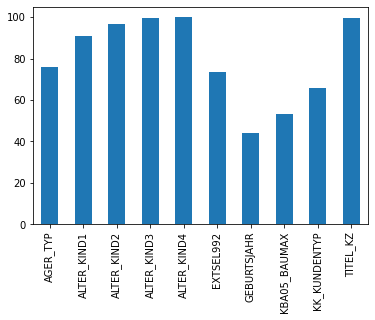

In [ ]:
azdias_missing_cols[azdias_missing_cols['percentage']>40]['percentage'].plot(kind="bar")

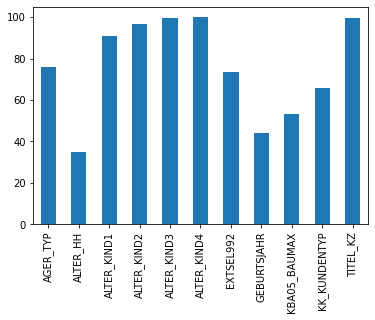

In [ ]:
azdias_missing_cols[azdias_missing_cols['percentage']>30]['percentage'].plot(kind="bar")

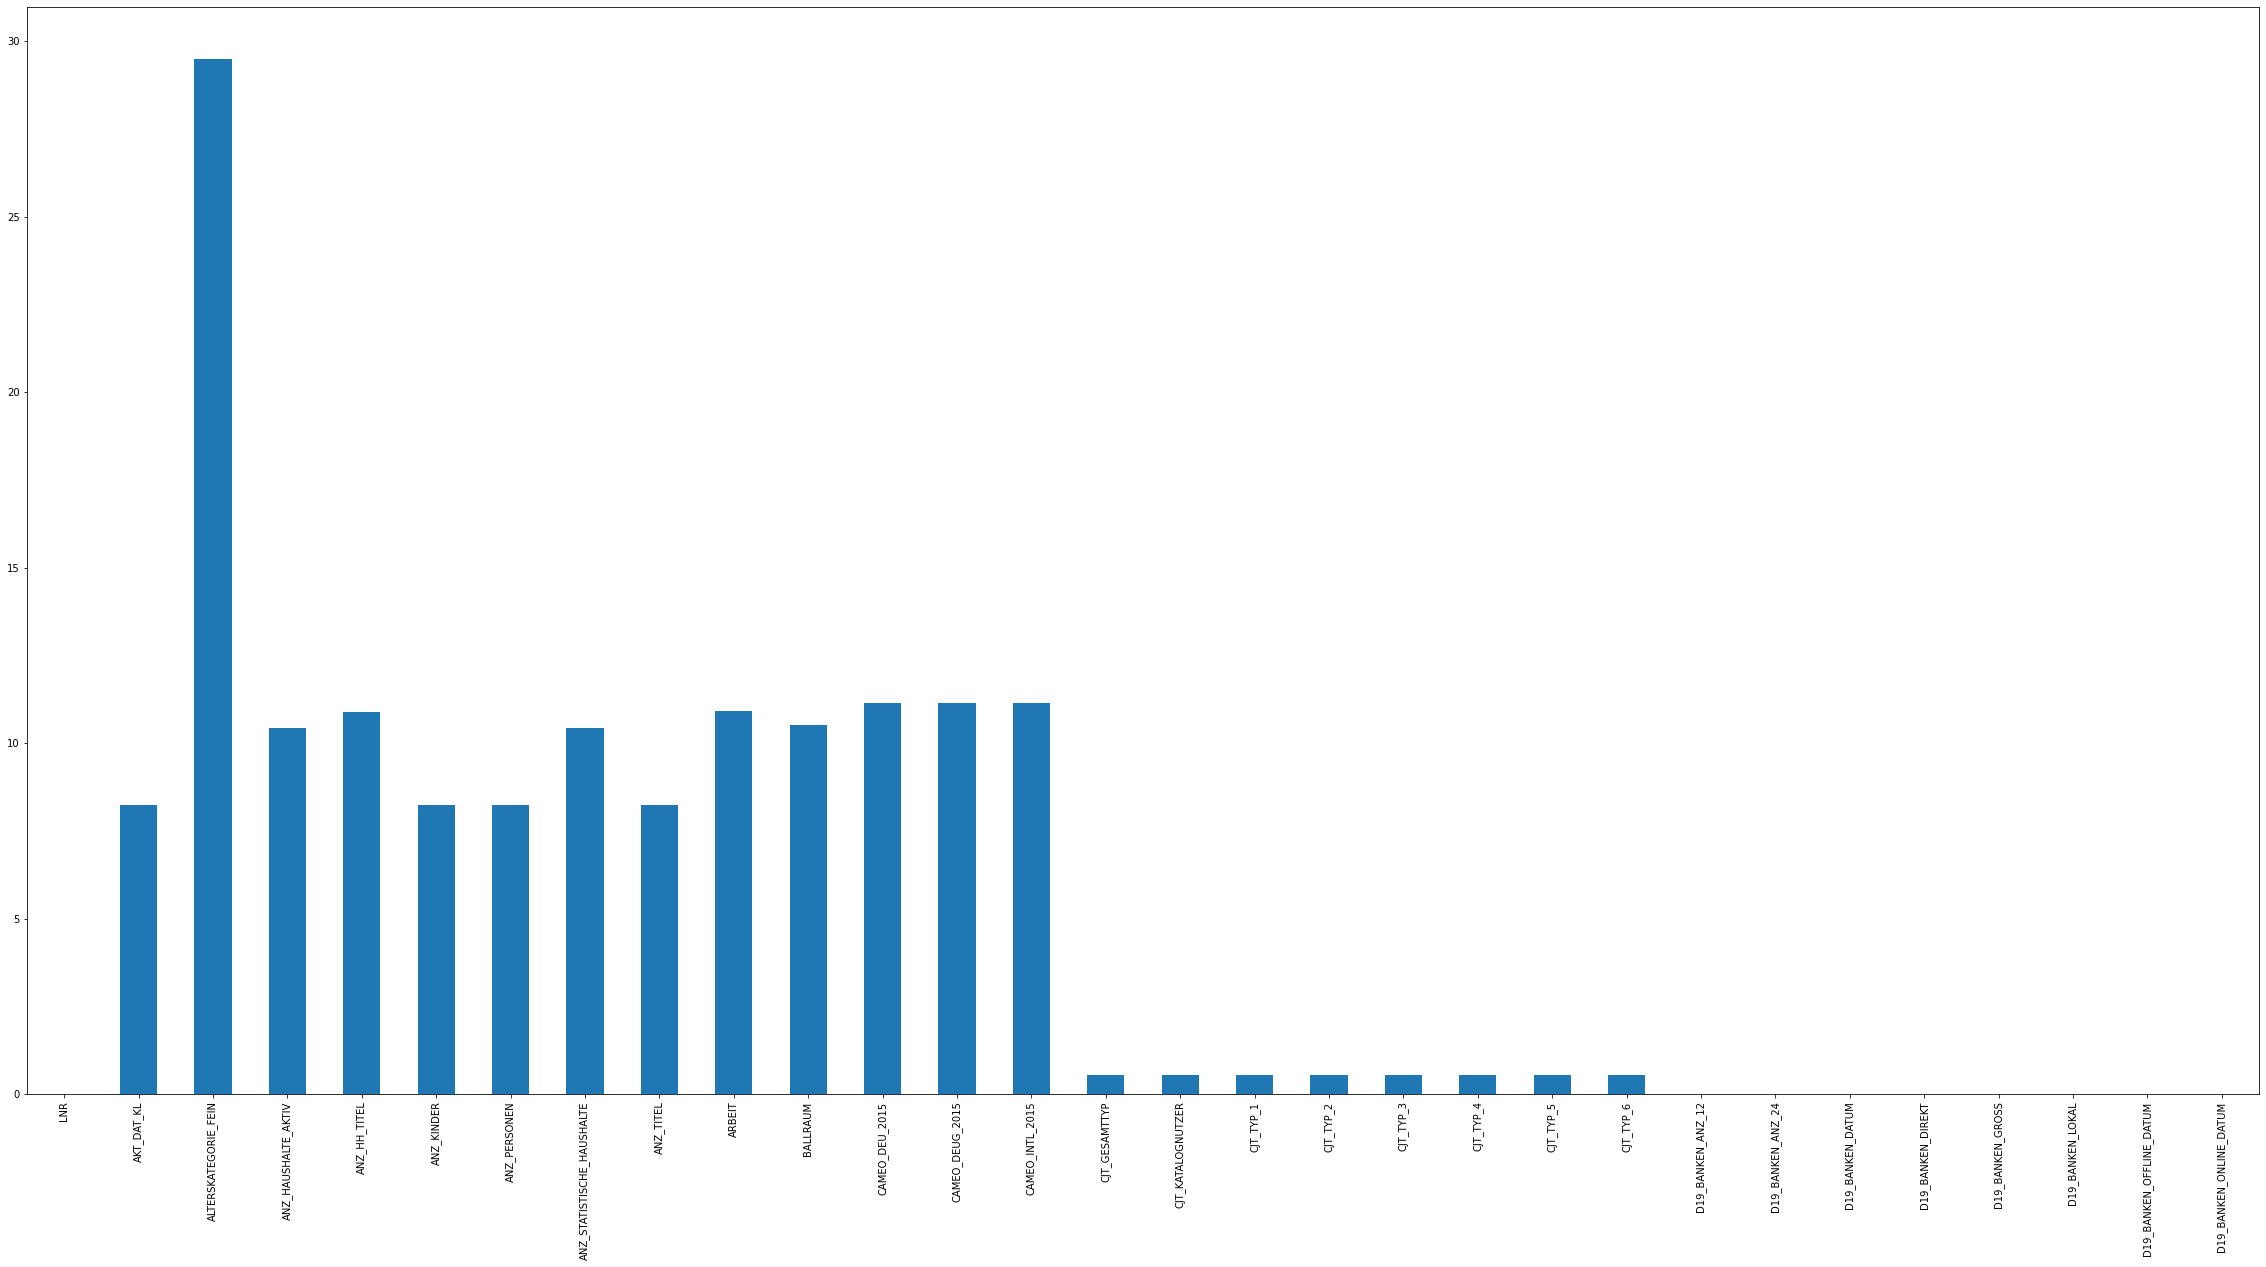

In [ ]:
azdias_missing_cols[azdias_missing_cols['percentage']<30]['percentage'][:30].plot(figsize=(40,20),kind="bar")

**Looking at indiidual cols and rows is making our decision bit tricky, so better to merge and compare percetages of azdias and customers missing column datasets**

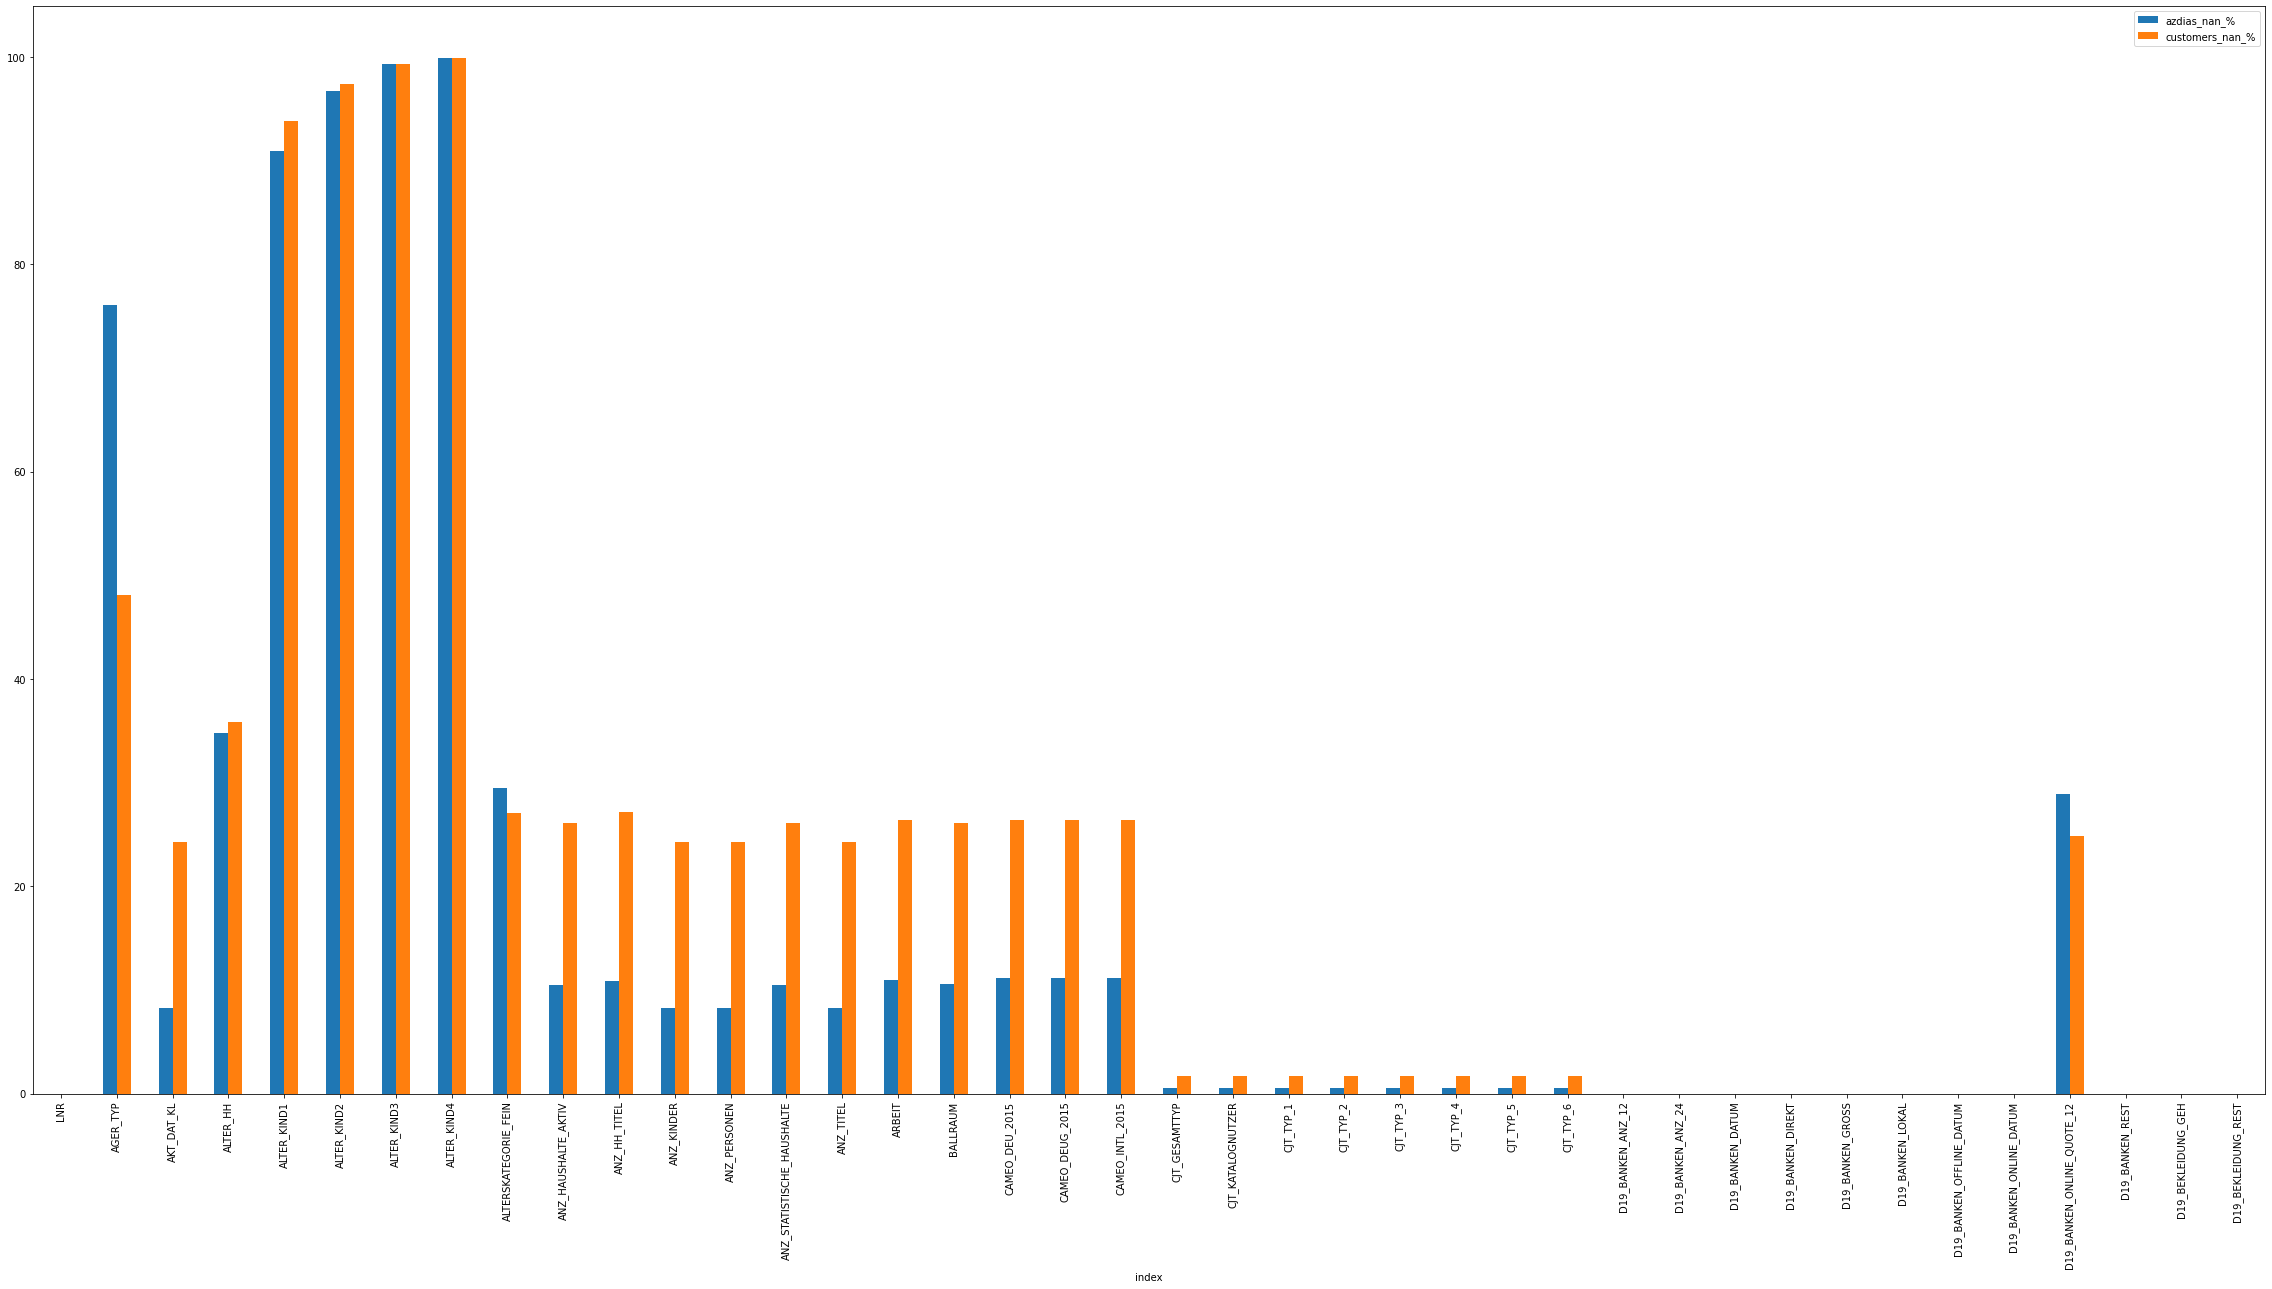

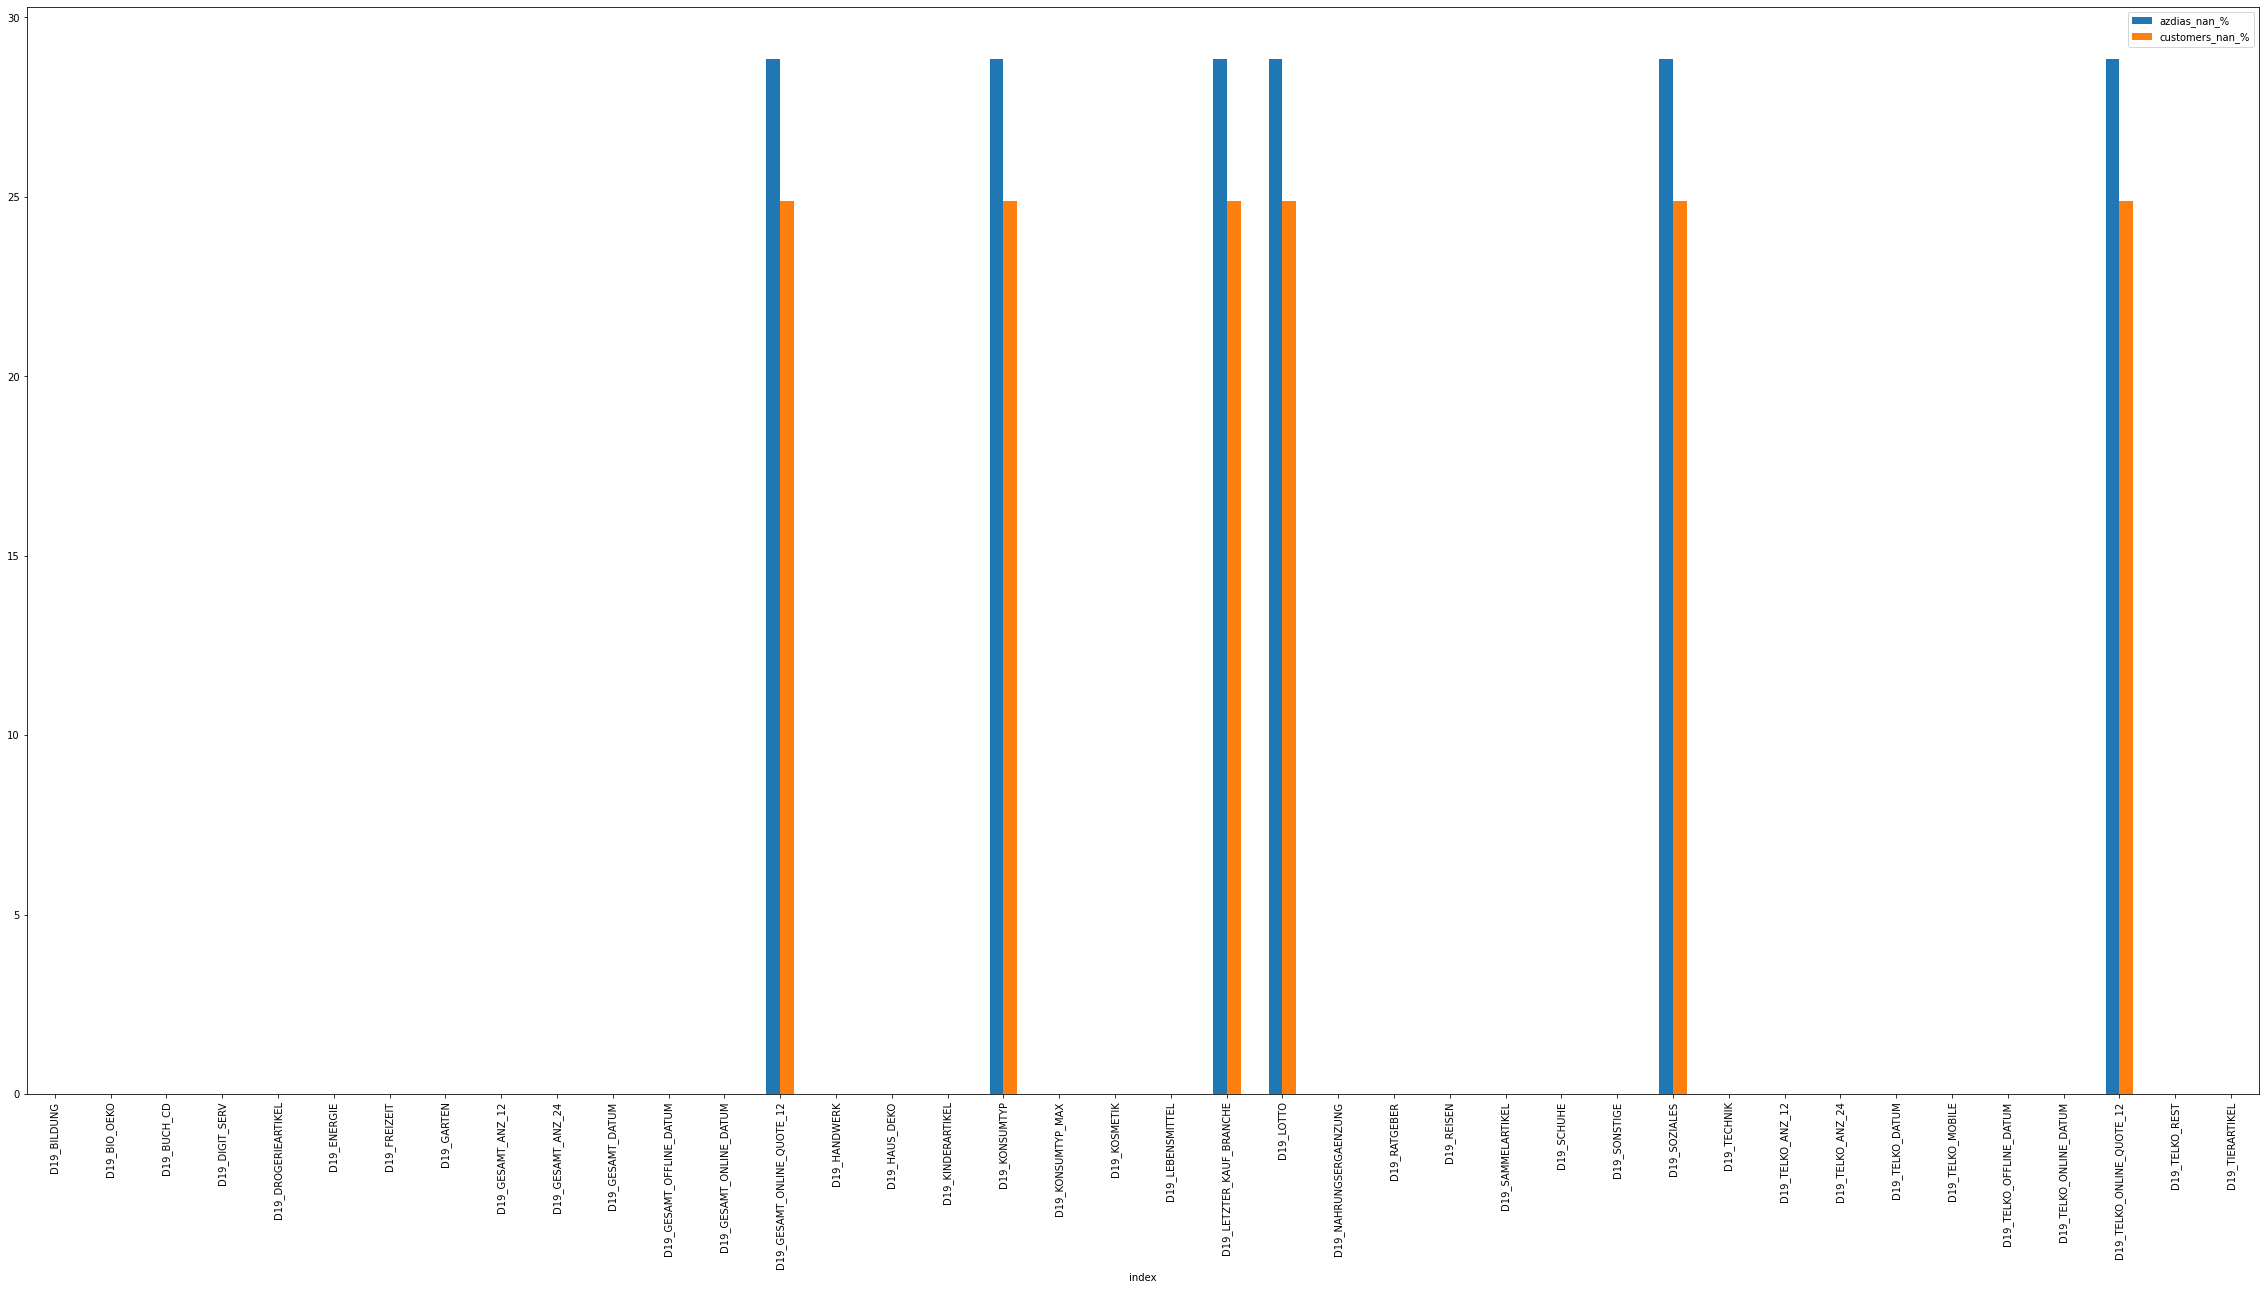

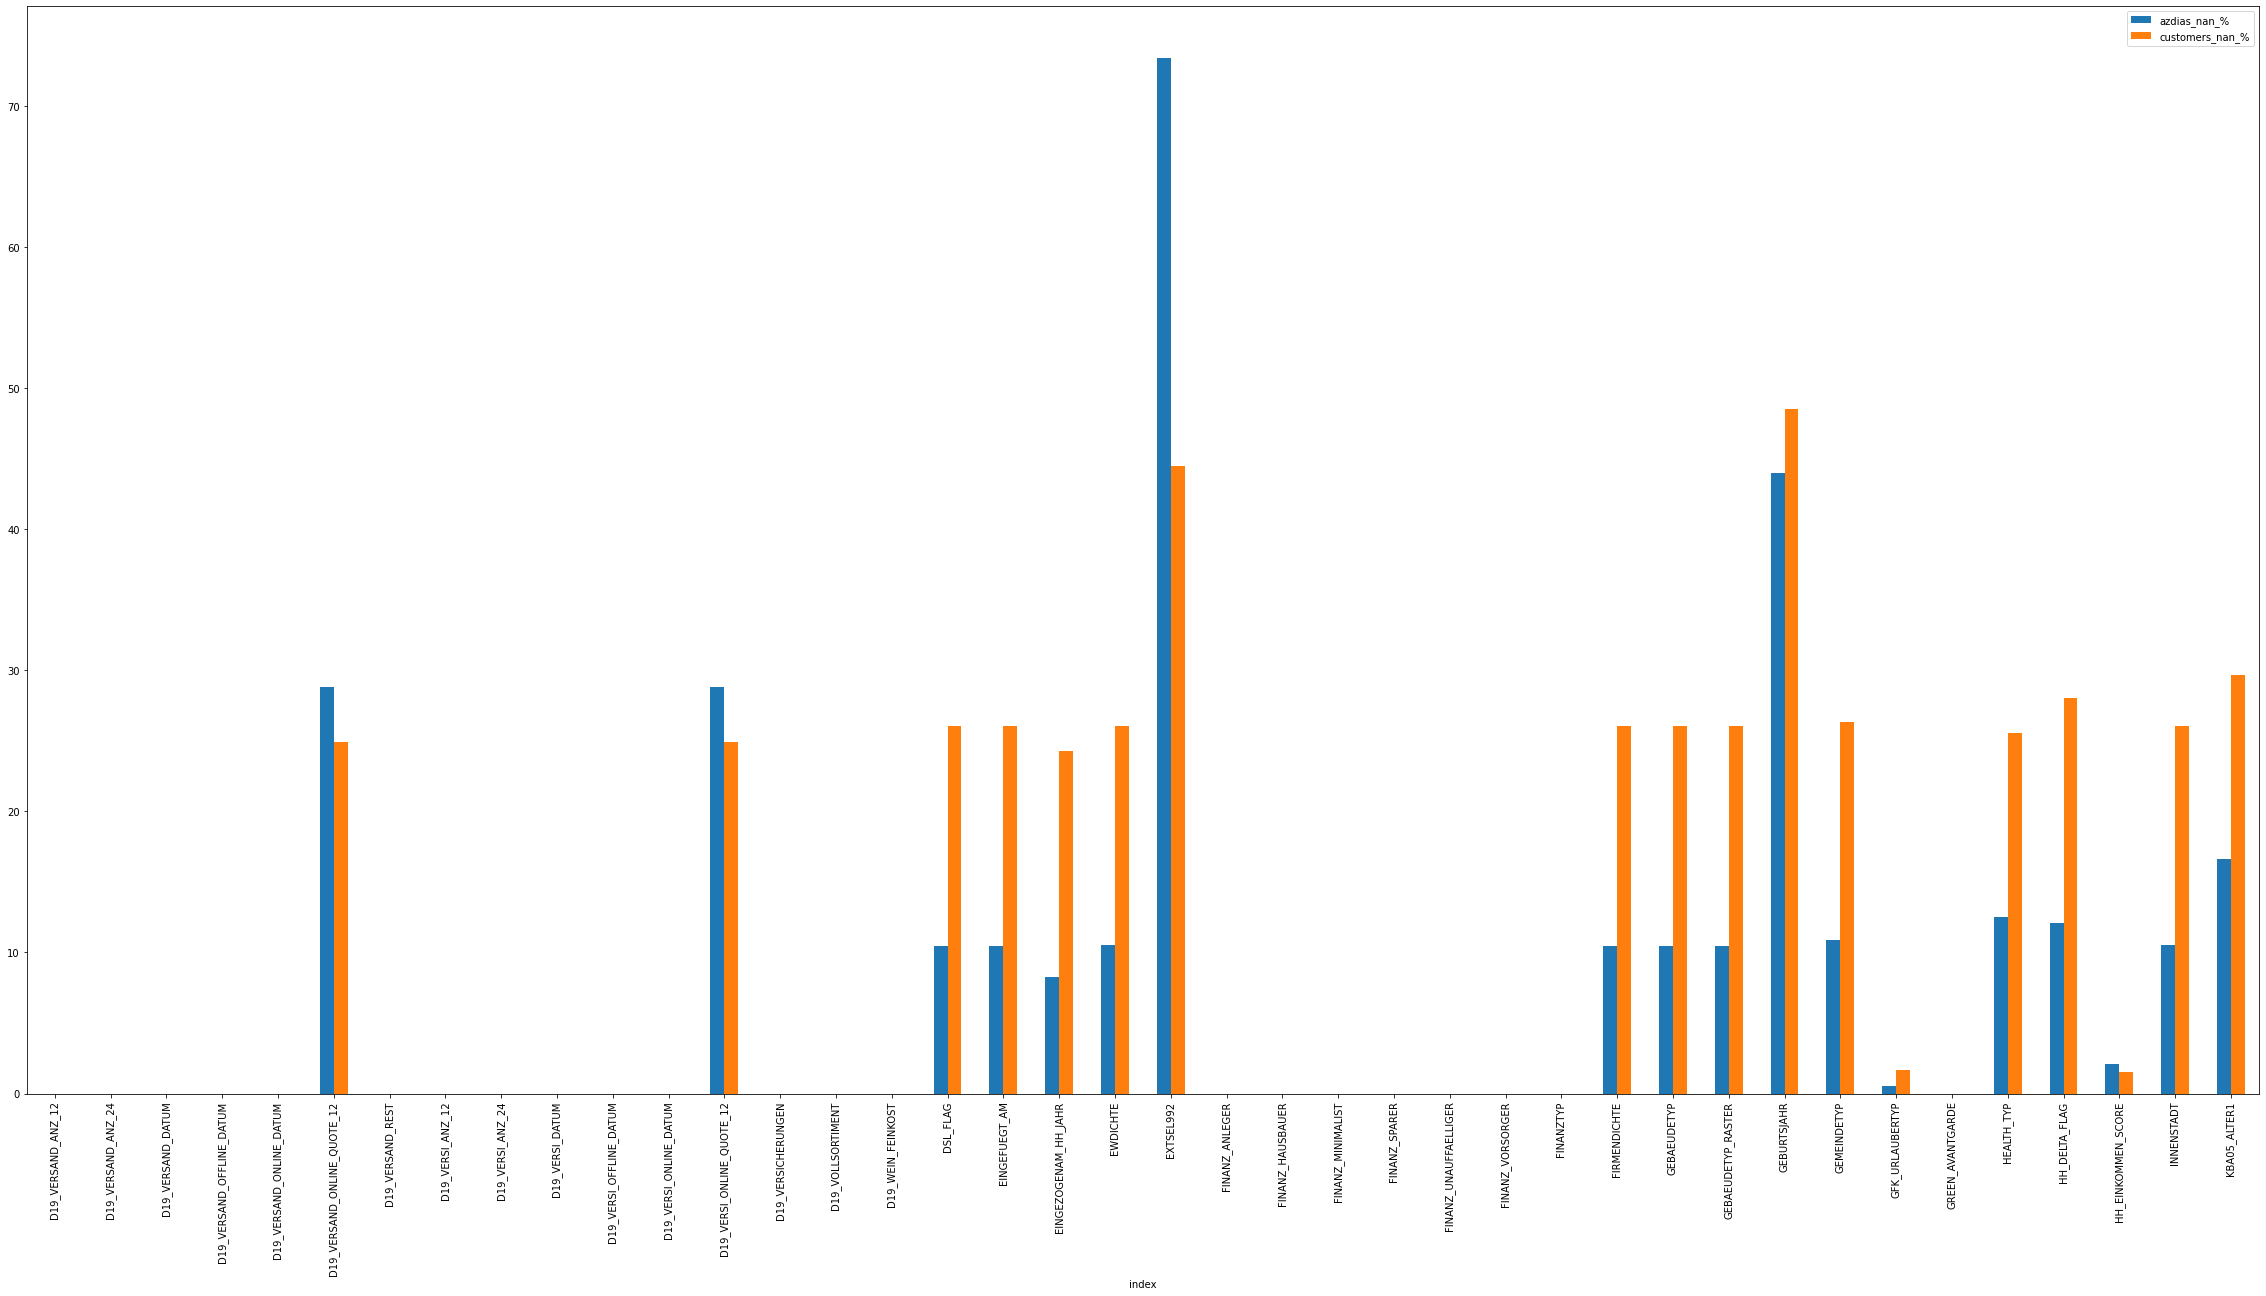

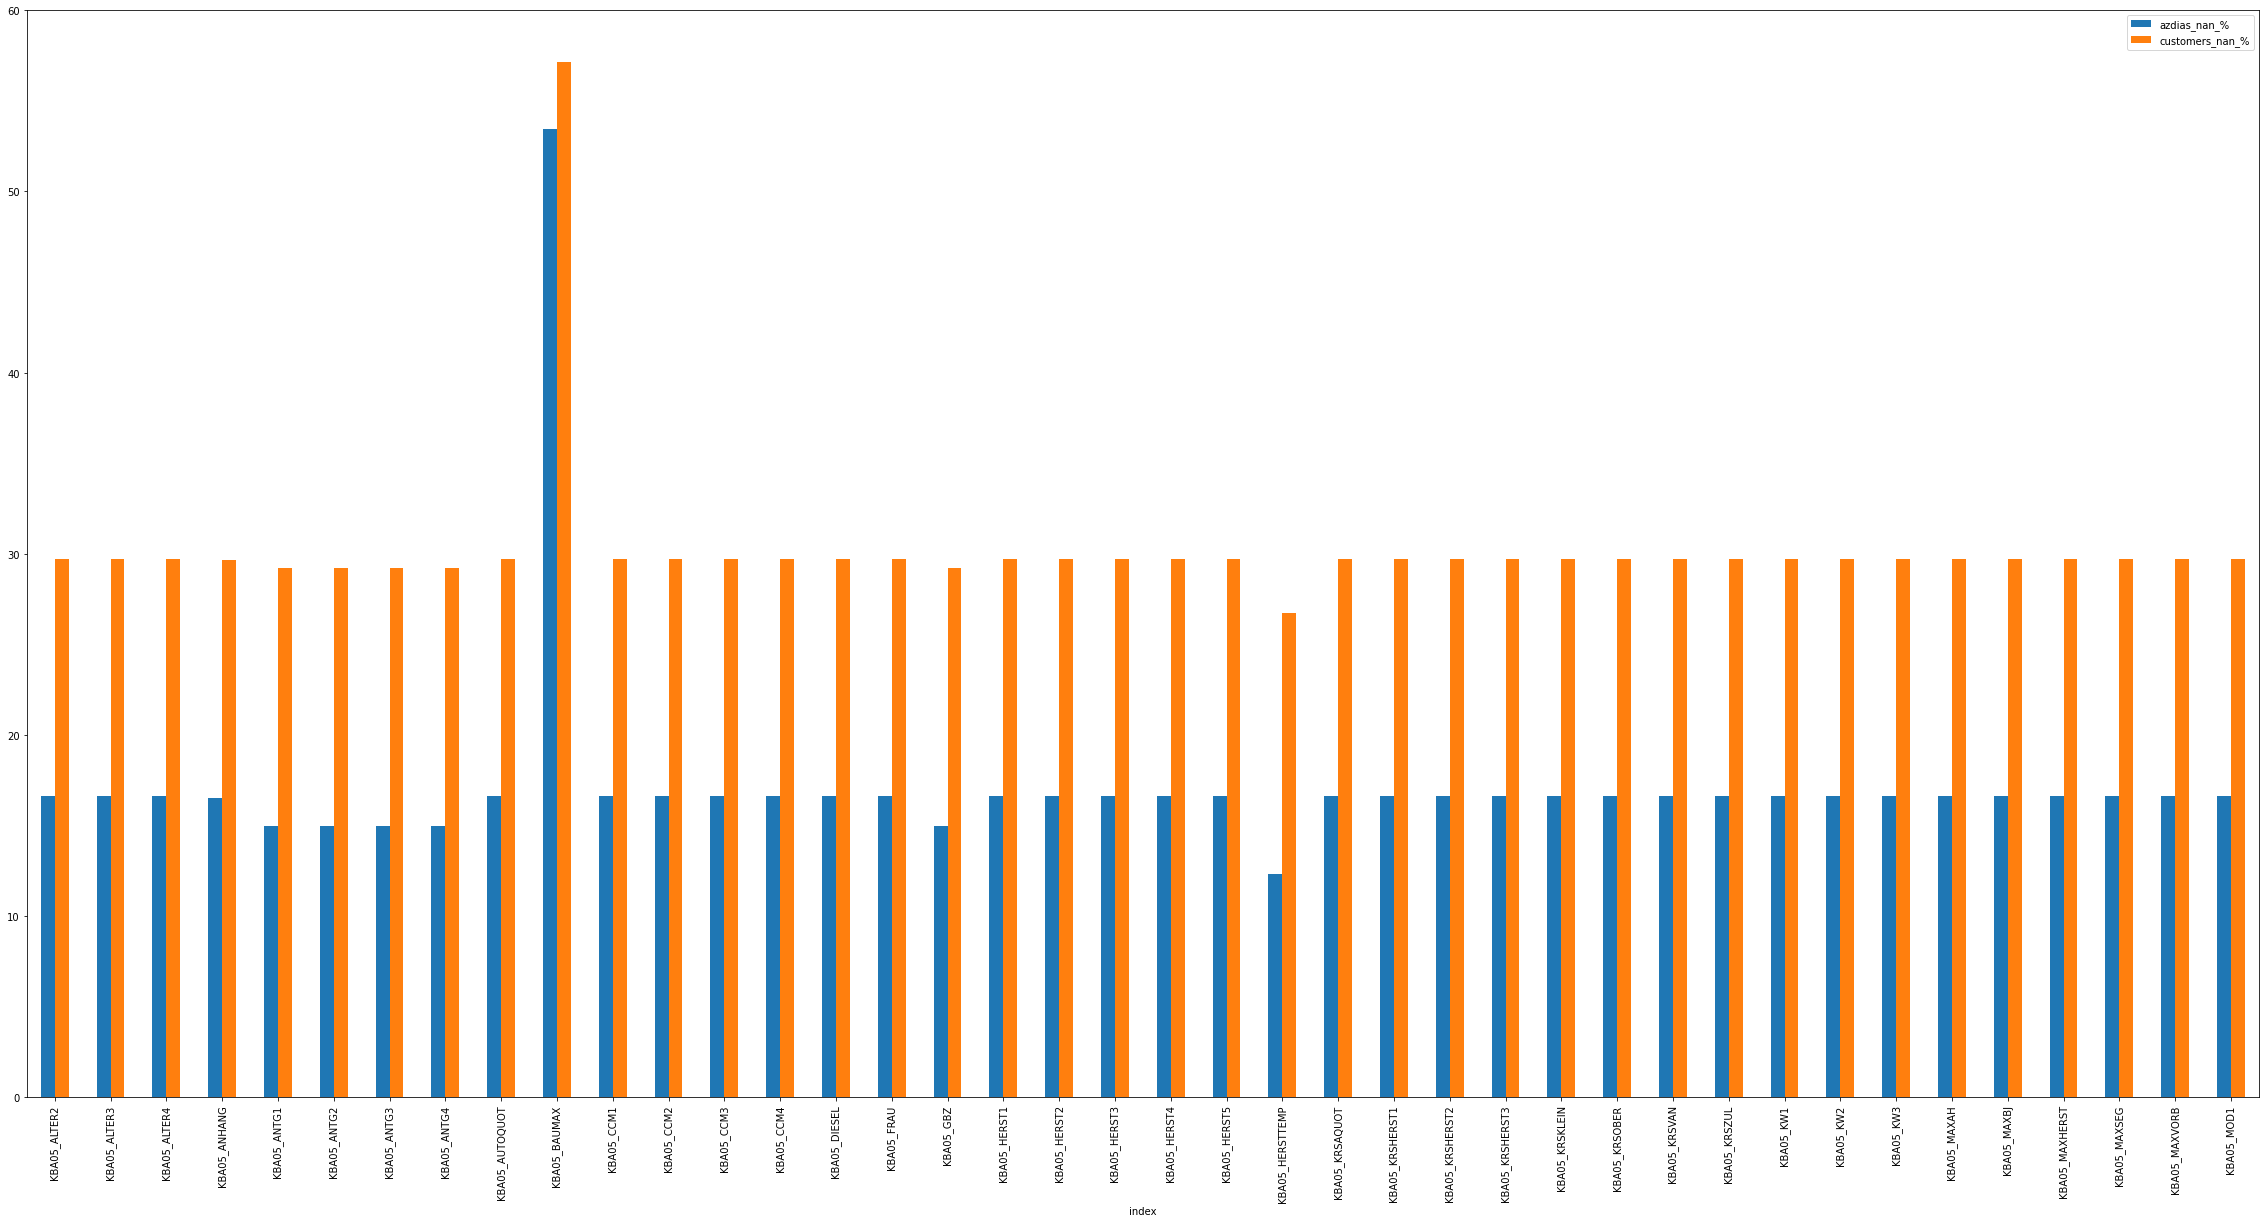

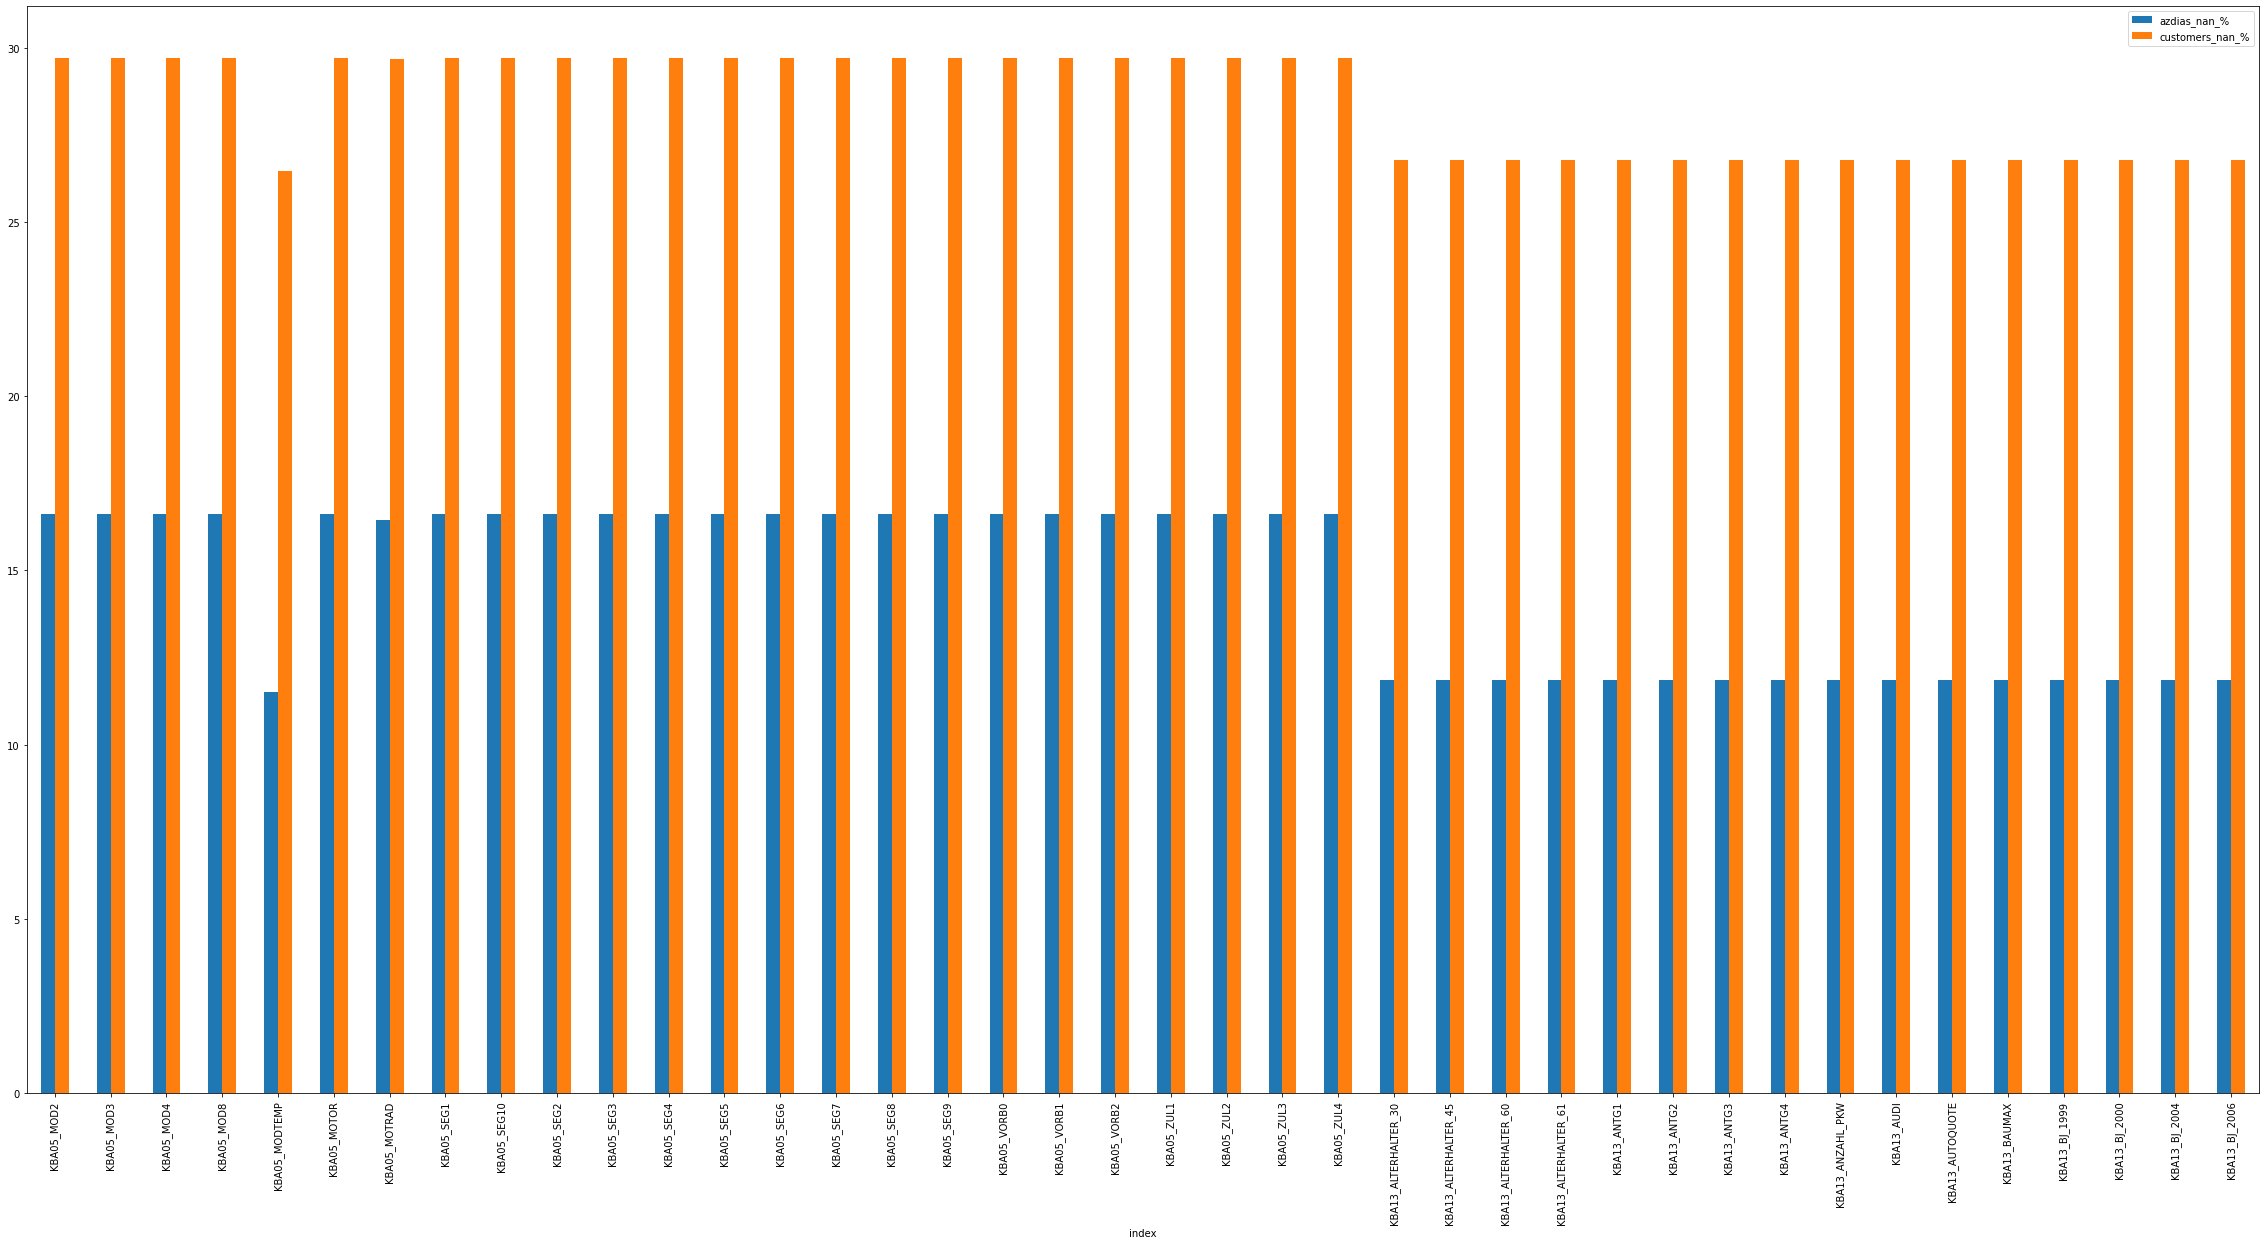

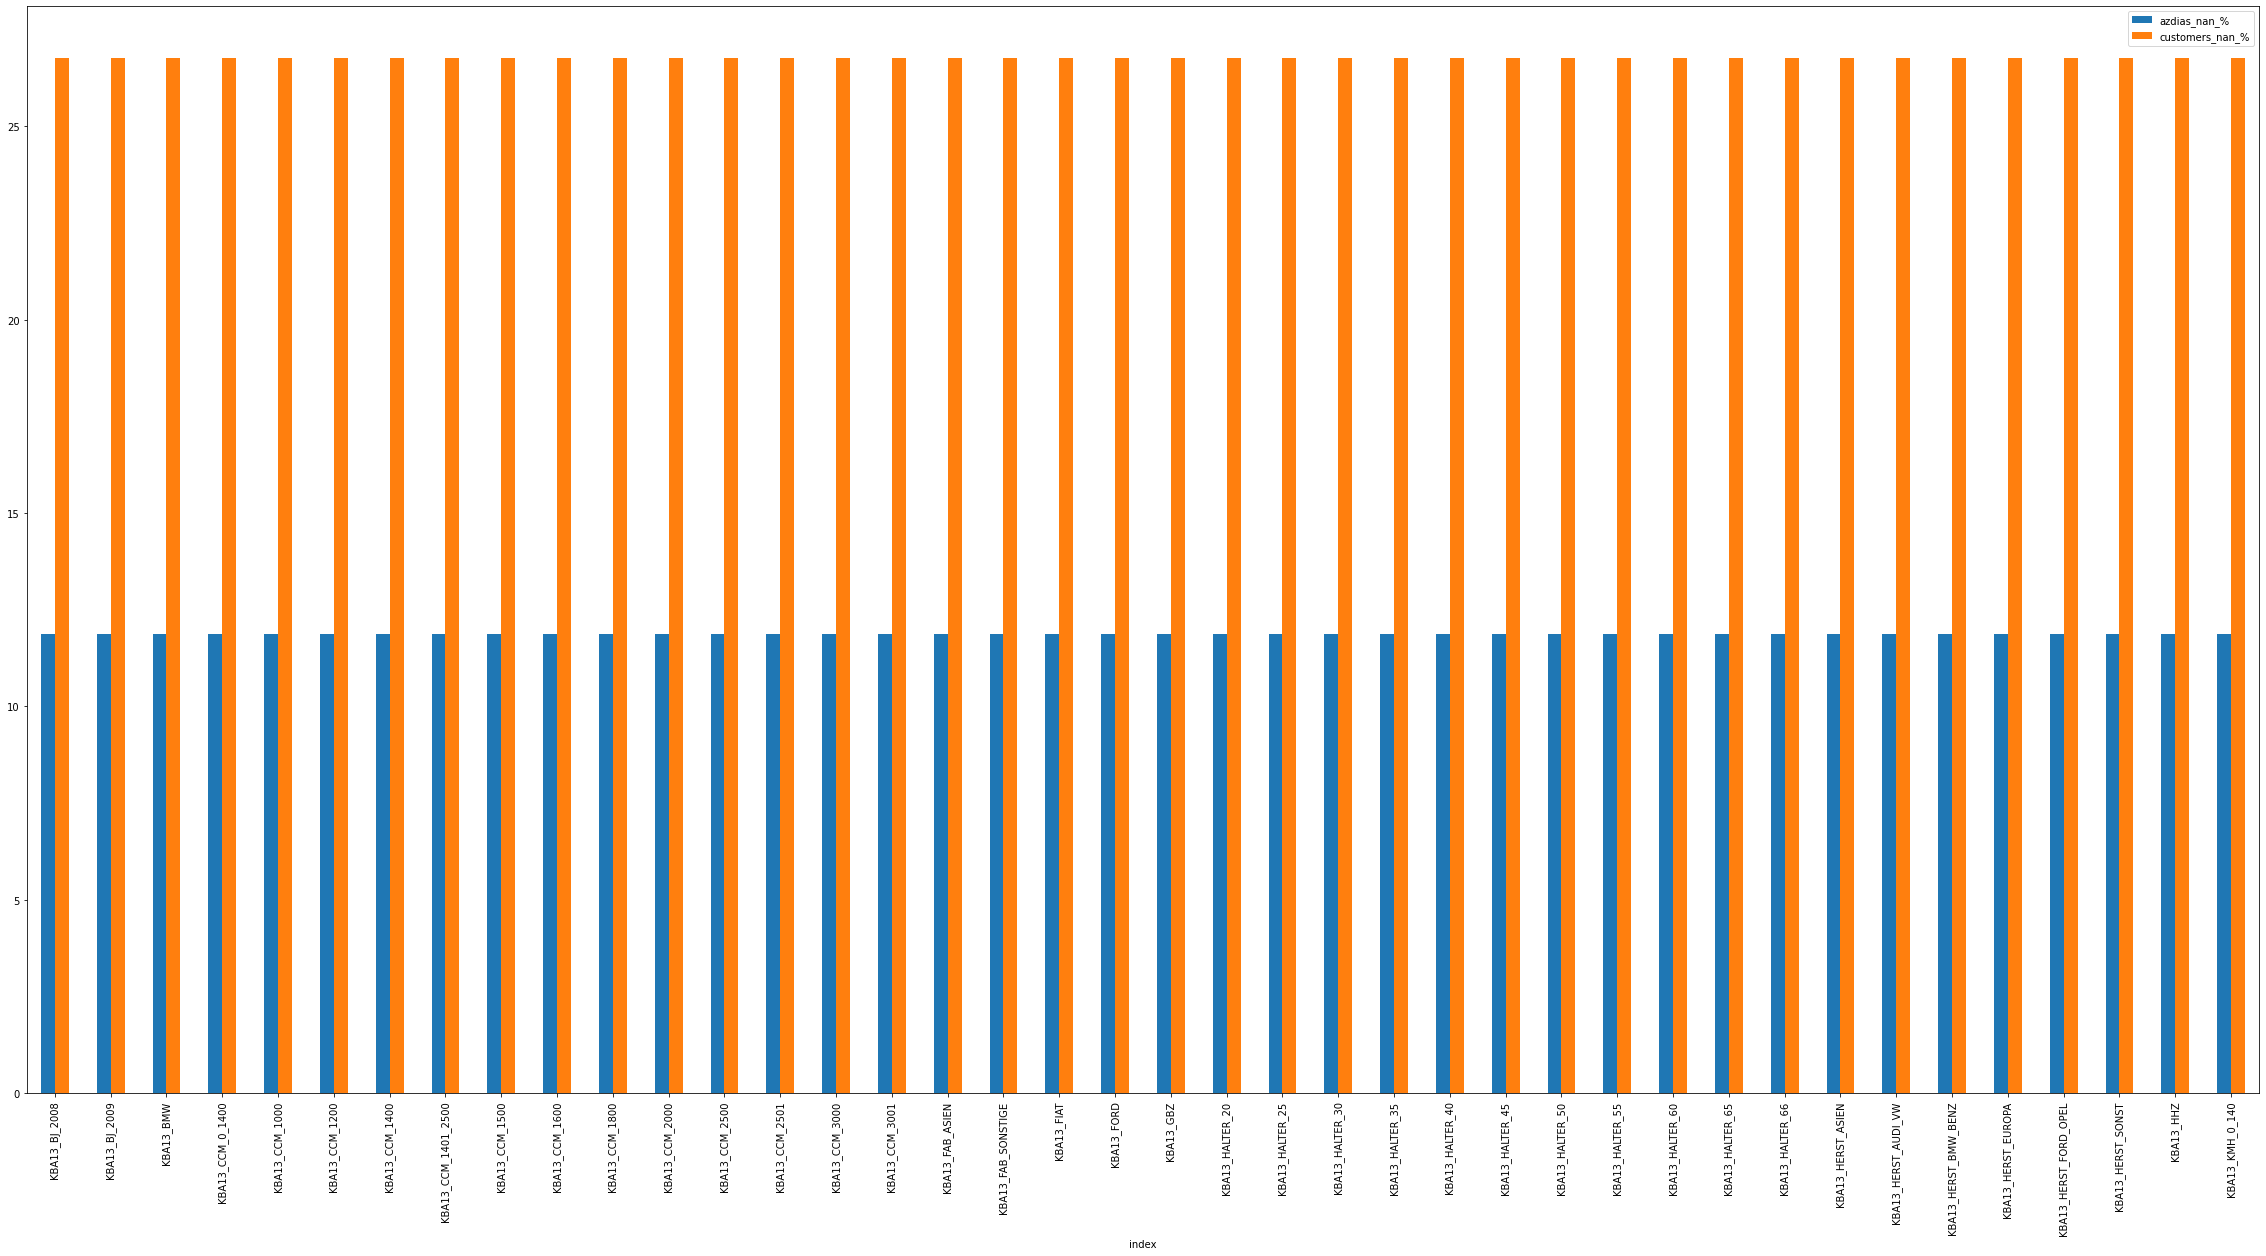

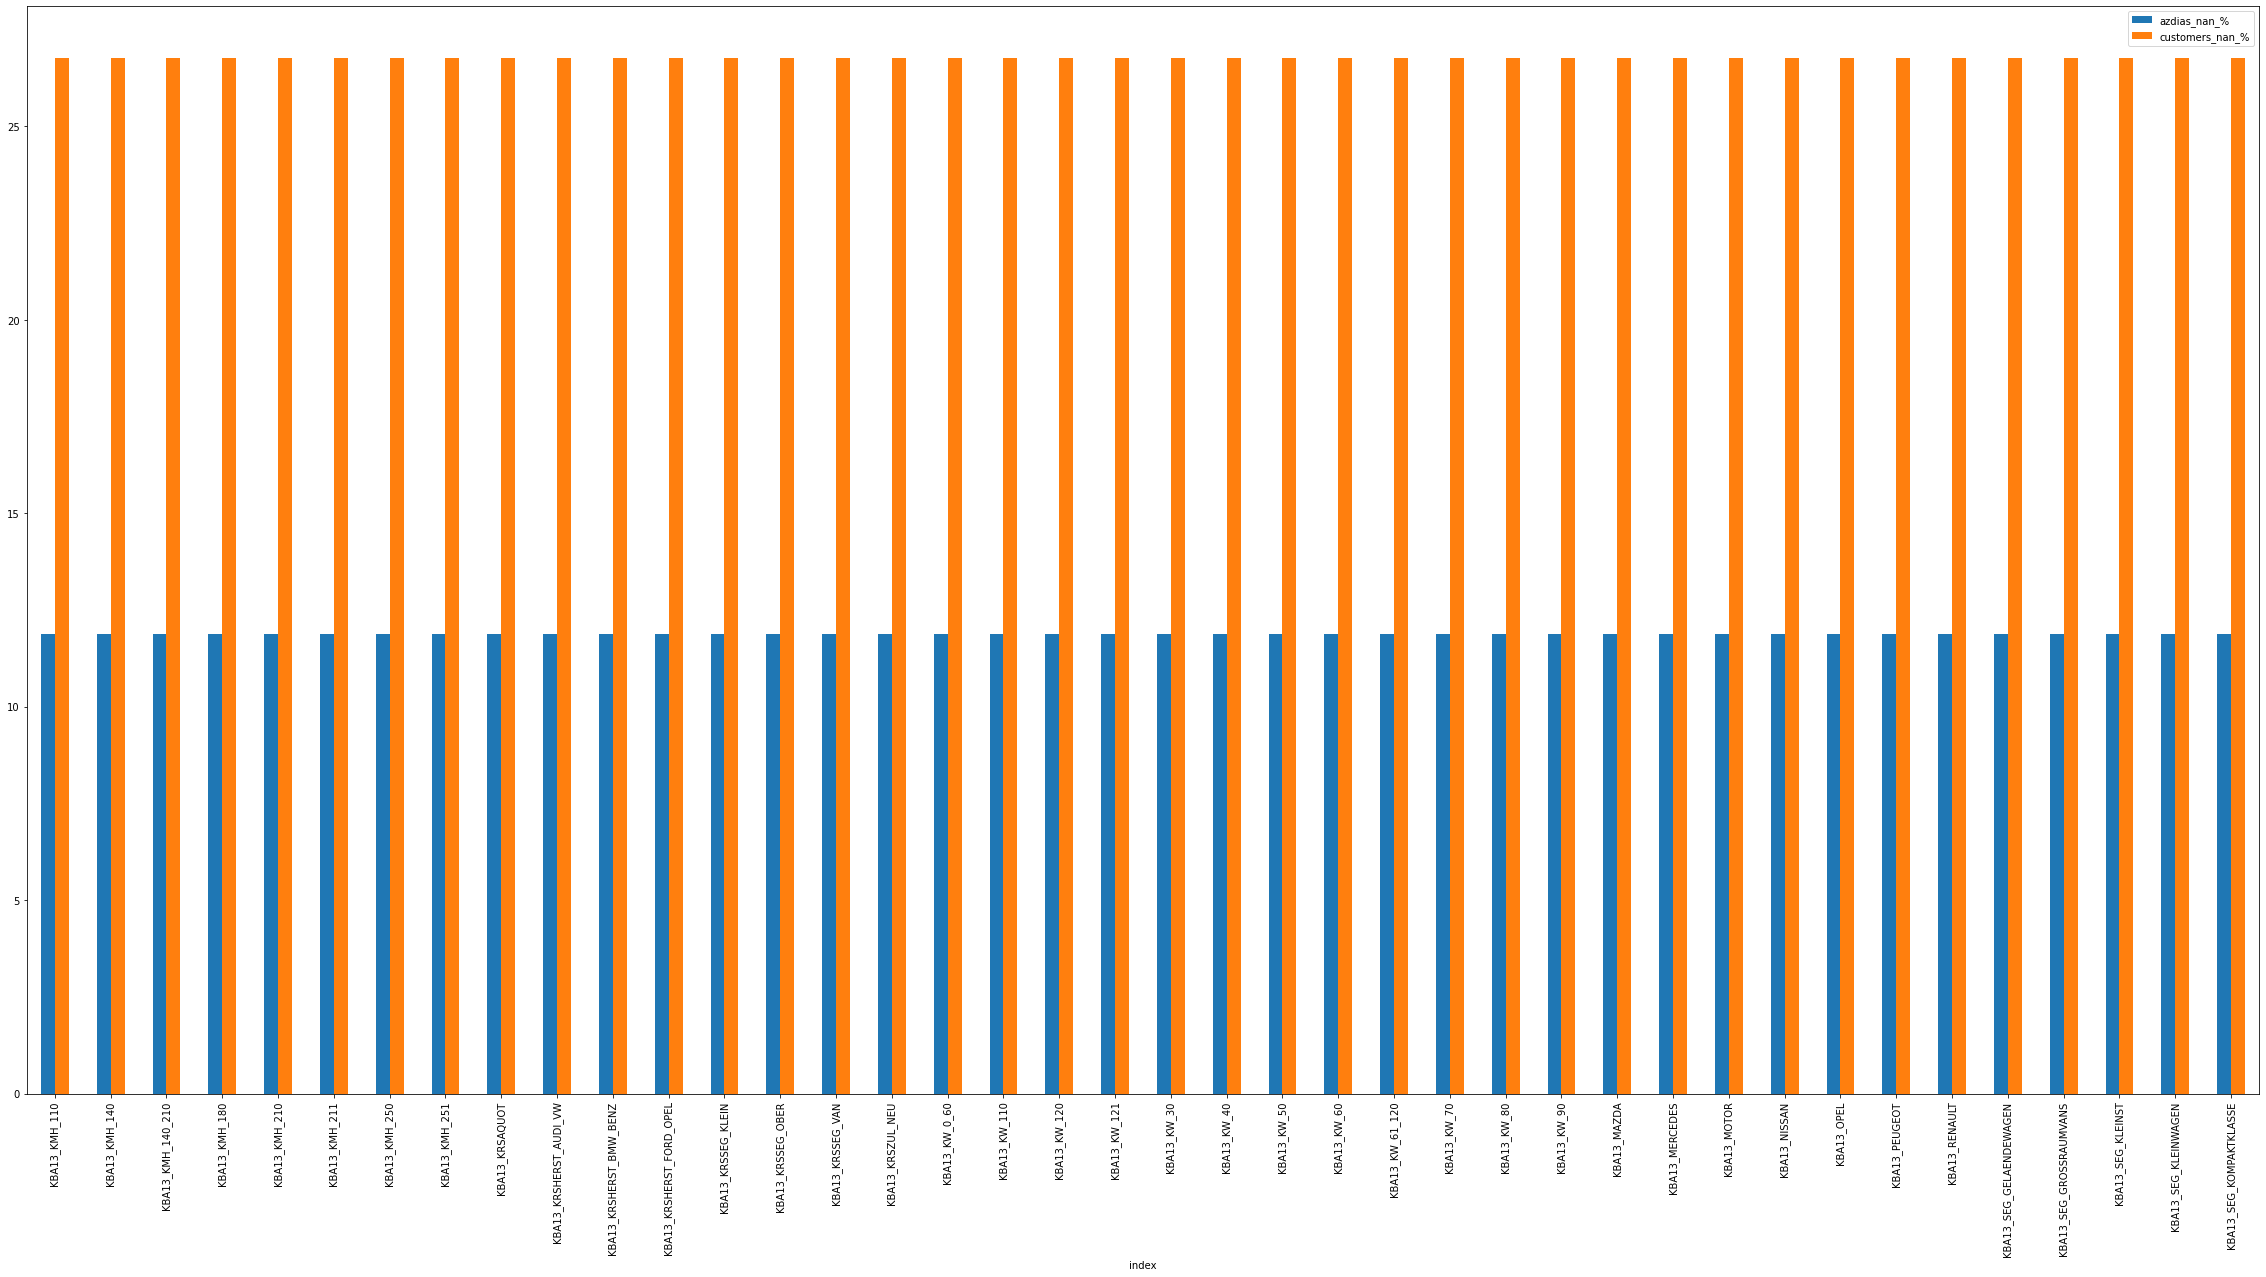

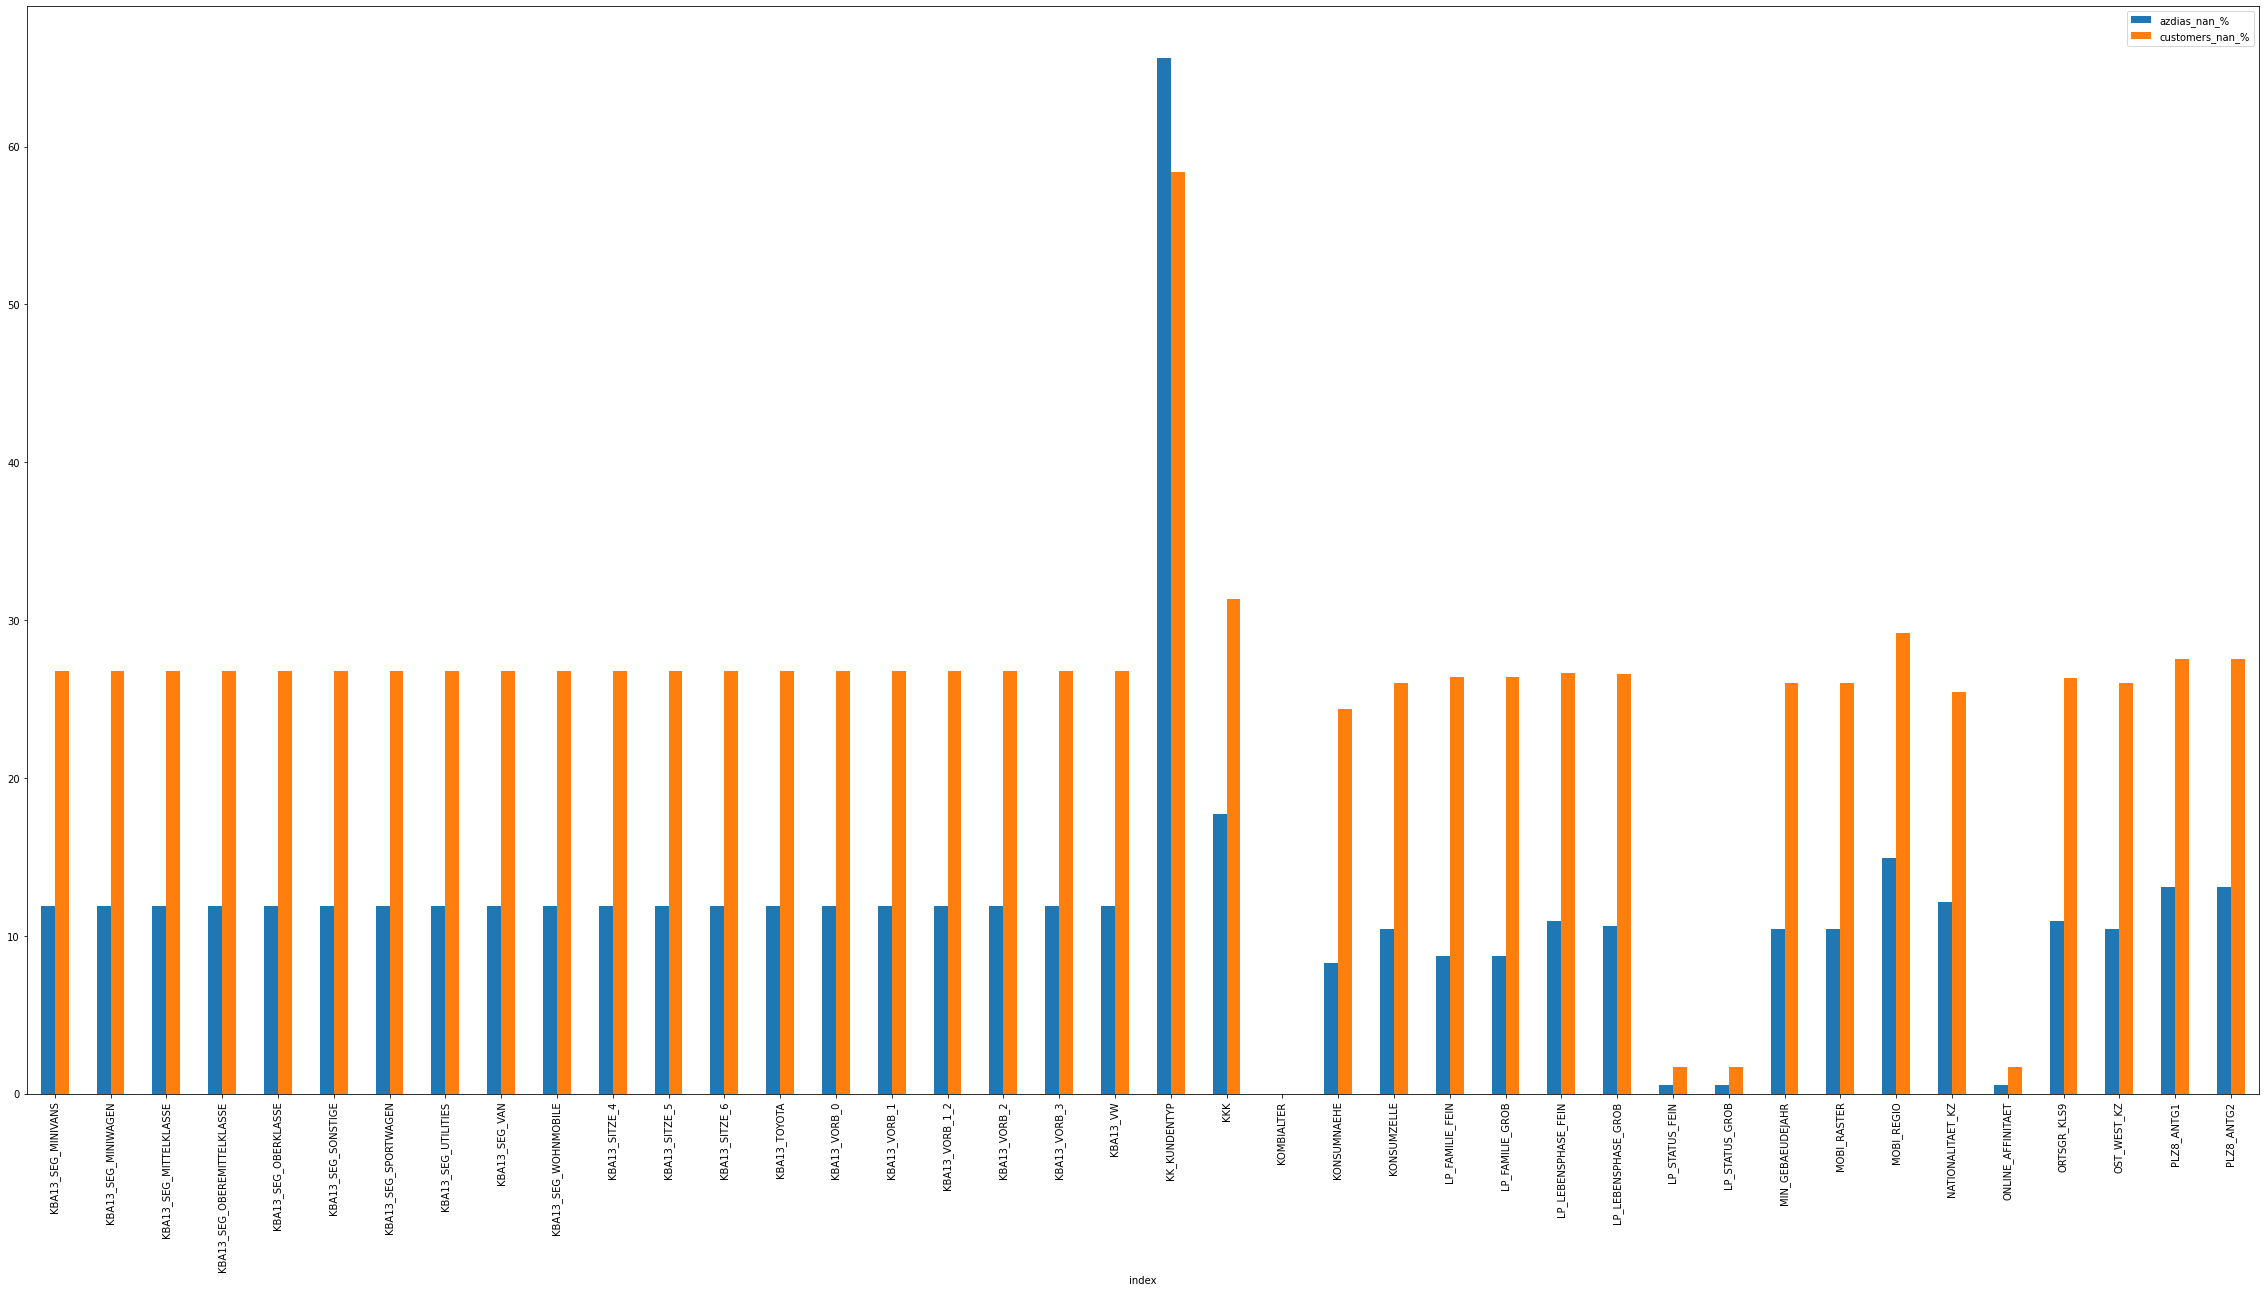

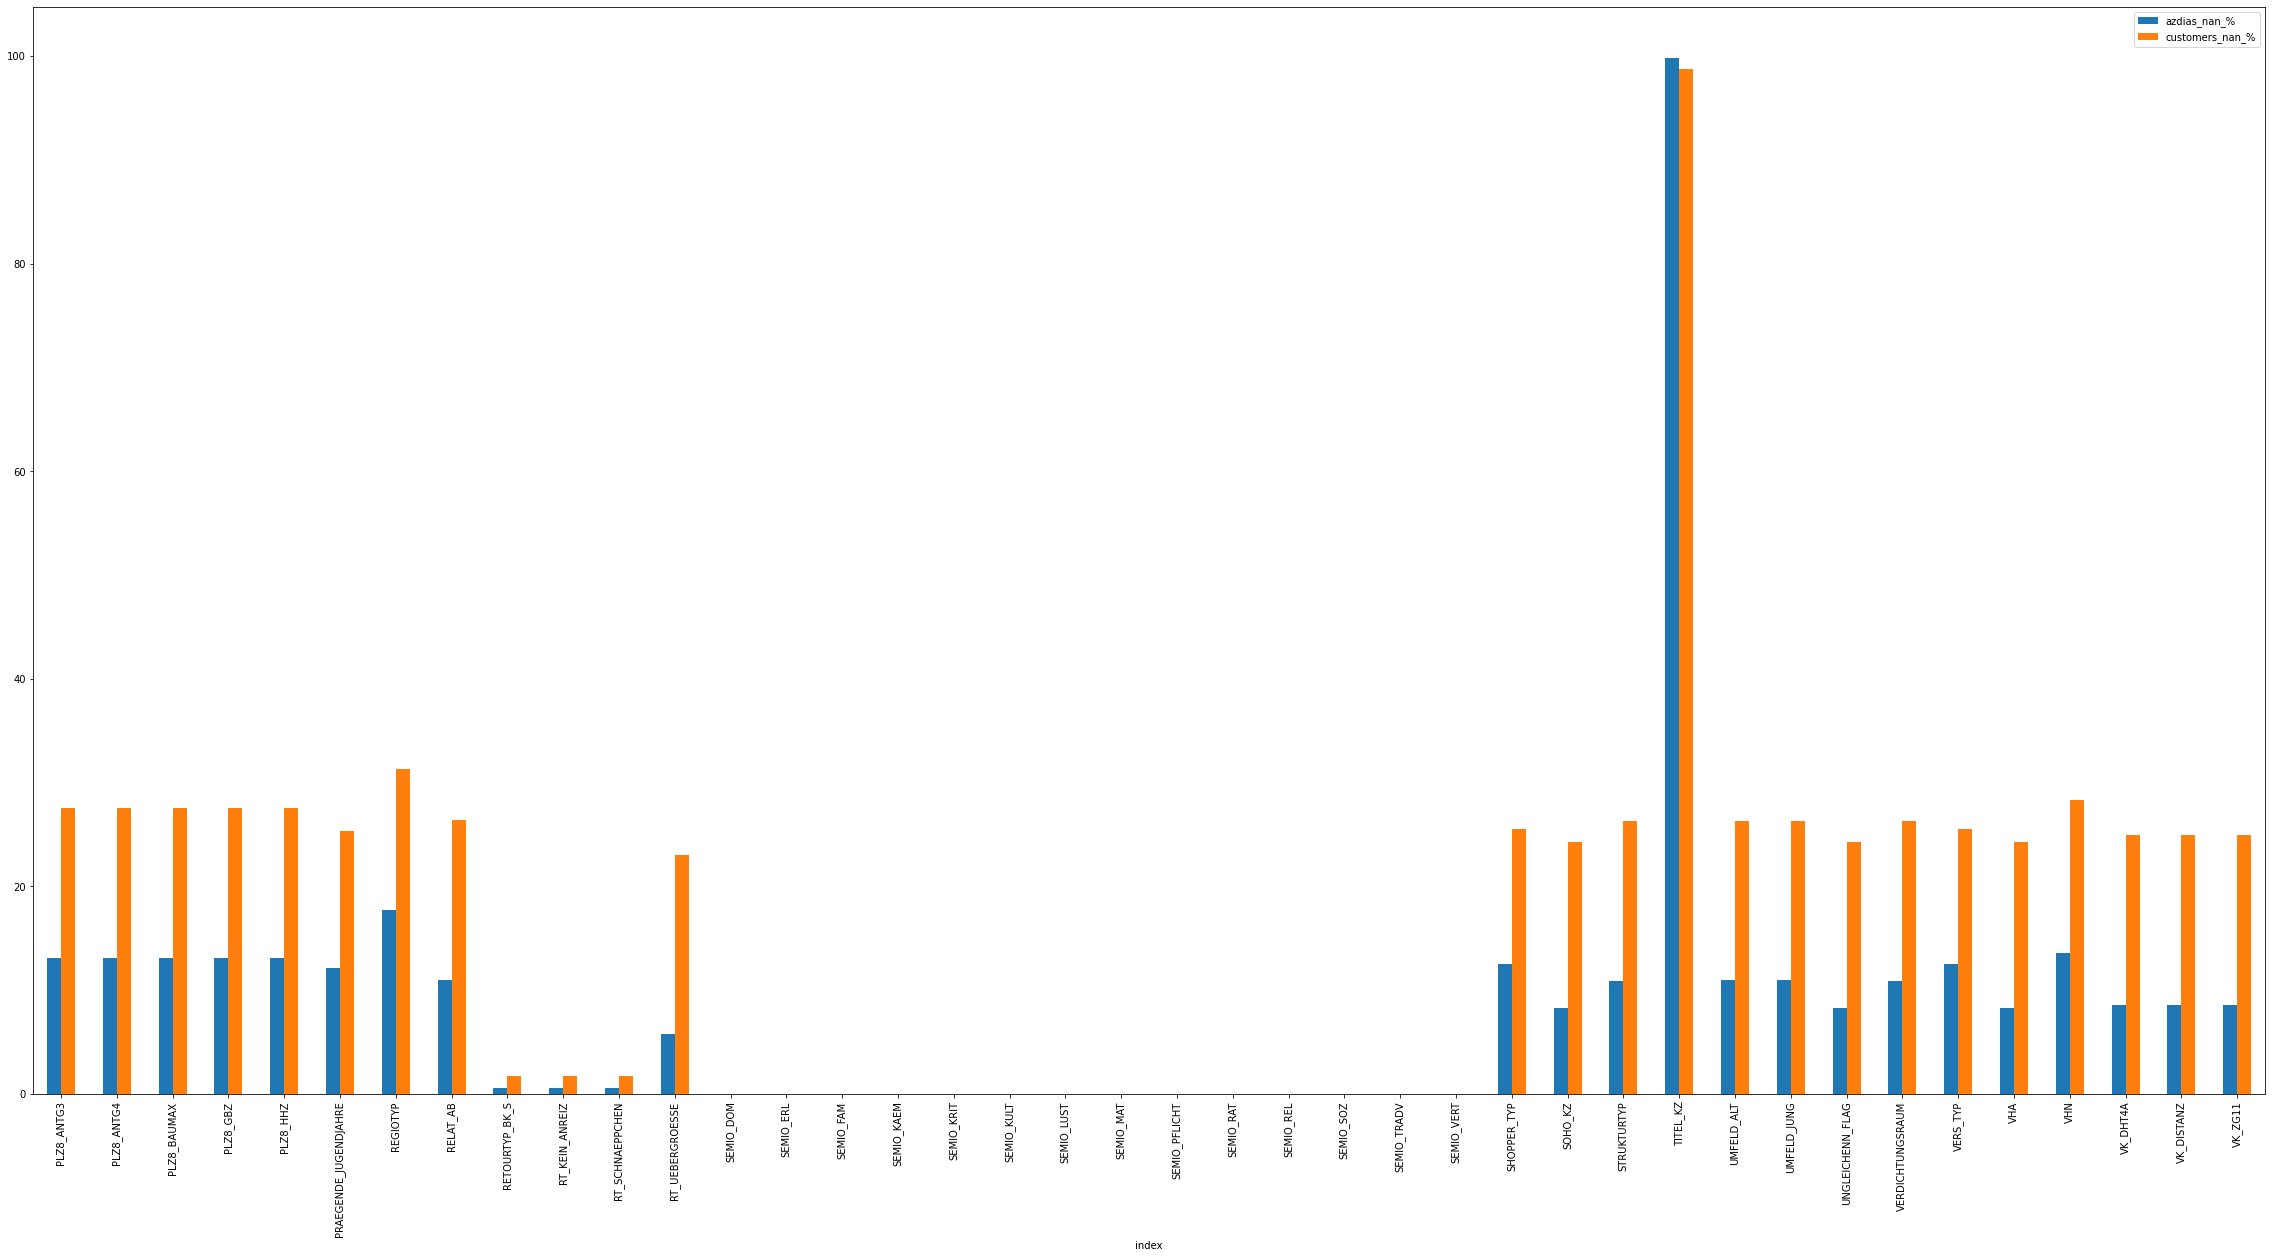

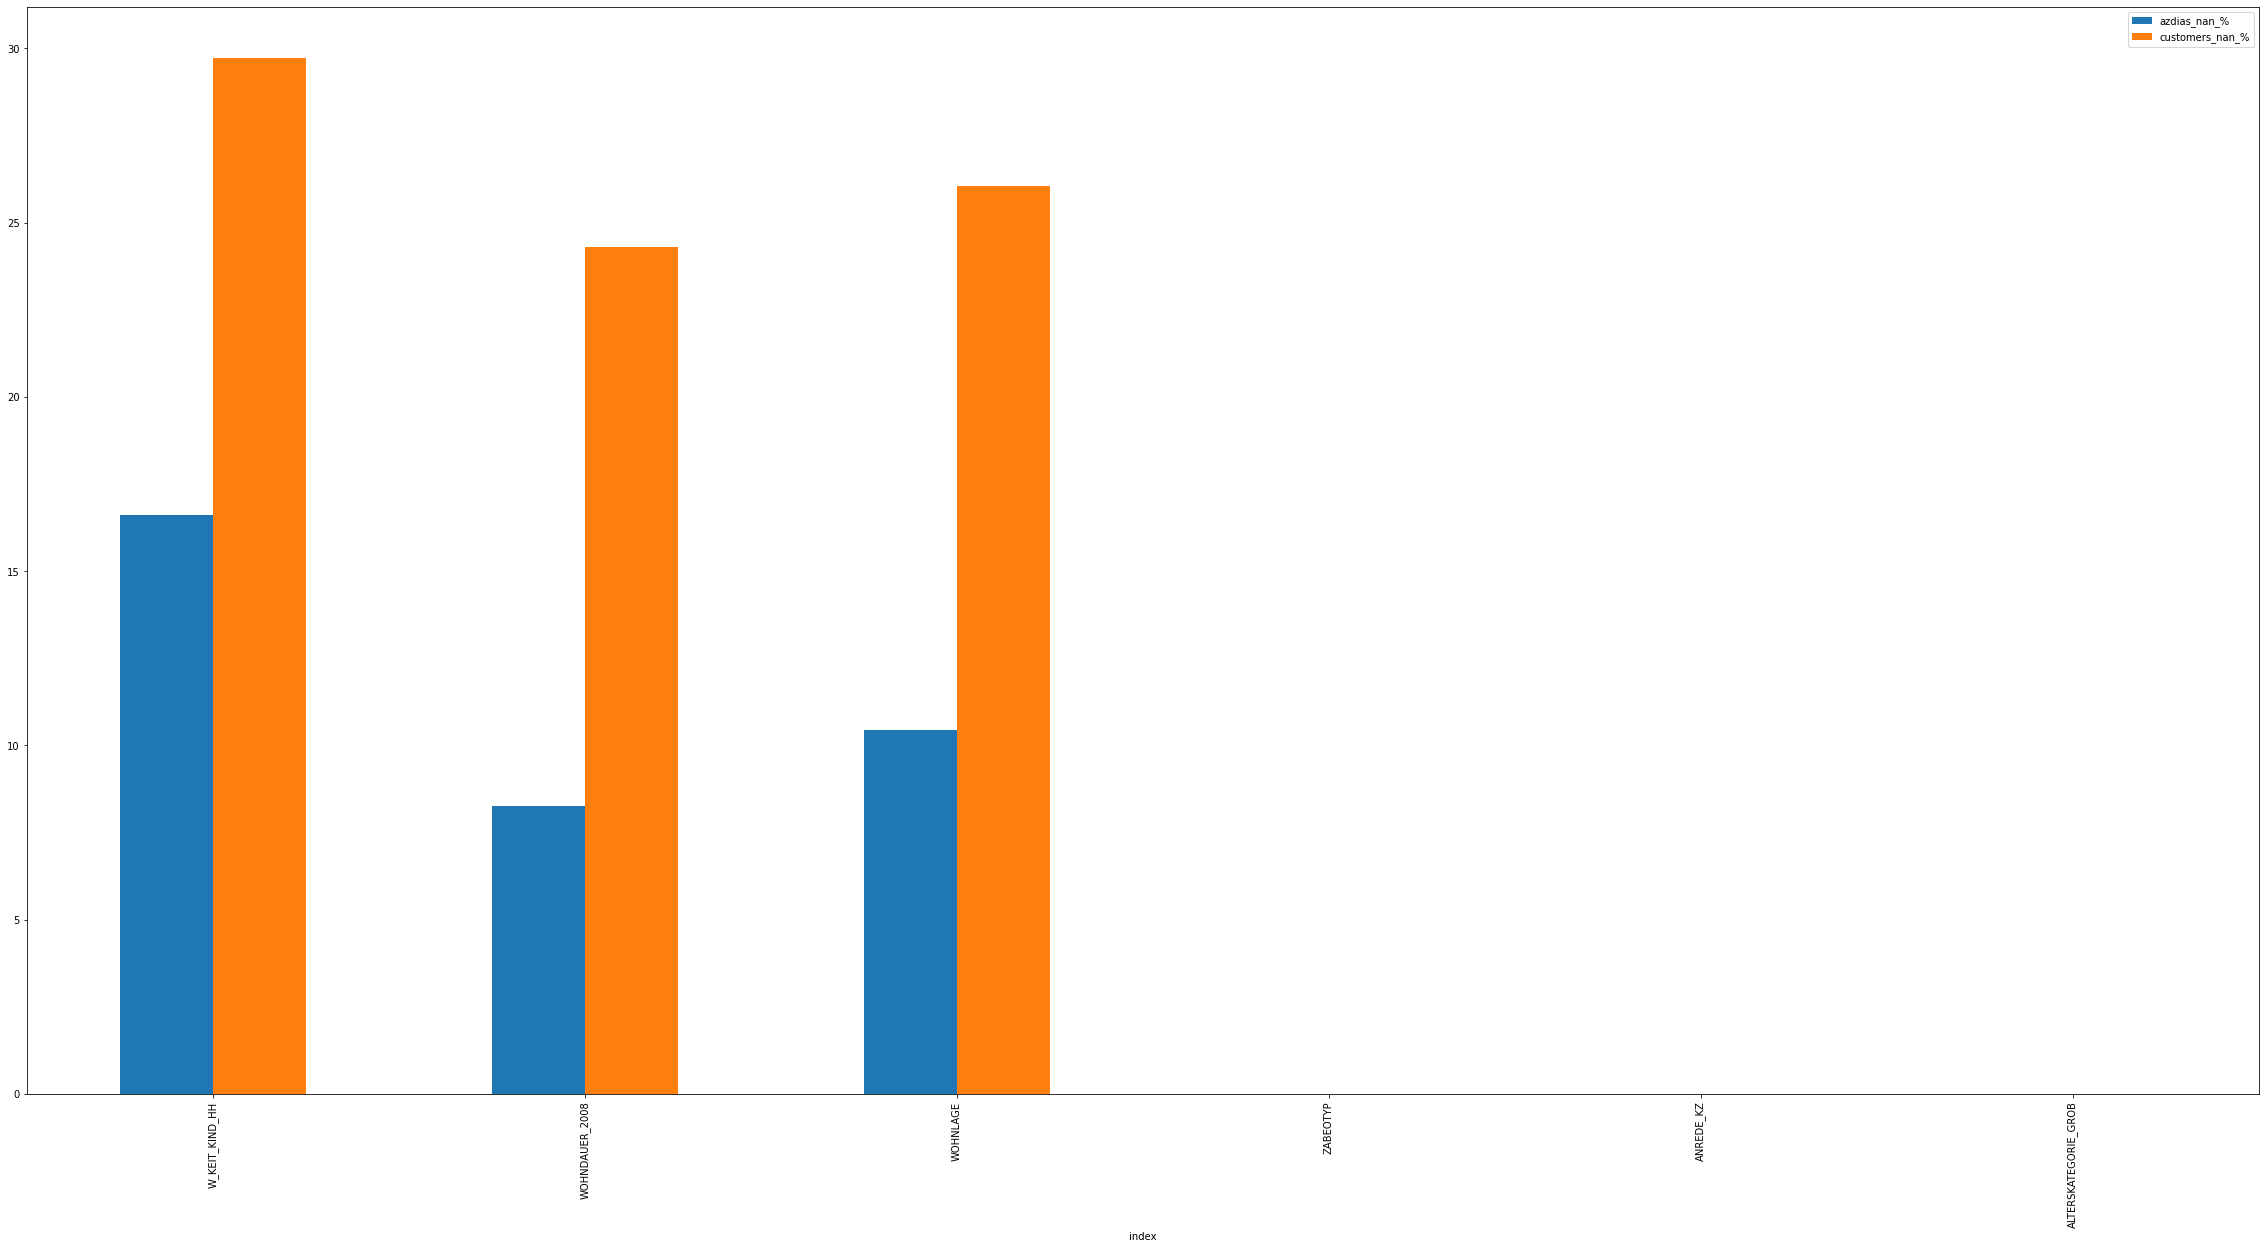

In [ ]:
merged_dataframe = azdias_missing_cols.reset_index()
merged_dataframe = merged_dataframe.drop('count',axis=1)
merged_dataframe.rename(columns={'percentage':'azdias_nan_%'}, inplace=True)
temp = customer_missing_cols.reset_index()
temp = temp.drop('count',axis=1)
temp.rename(columns={'percentage':'customers_nan_%'}, inplace=True)
merged_dataframe = merged_dataframe.merge(temp,on='index')
for i in range(0,366,40):
    merged_dataframe[i:i+40].plot(x="index",figsize=(40,20),kind="bar")

**From above inference, I am willing to drop all the columns that have nan vales greater than 30**

In [ ]:
drop_cols = list(merged_dataframe.loc[(merged_dataframe['azdias_nan_%'] > 30) & (merged_dataframe['customers_nan_%'] > 30)]['index'])
filtered_azdias = filtered_azdias.drop(drop_cols, axis = 1)
filtered_customers = filtered_customers.drop(drop_cols, axis = 1)
drop_cols = list((set(filtered_azdias.columns) & set(filtered_customers.columns)).difference(set(list(attr_desc['Attribute']))))
filtered_azdias = filtered_azdias.drop(drop_cols, axis = 1)
filtered_customers = filtered_customers.drop(drop_cols, axis = 1)
print("Number of nan values left(azdias) : {} ".format(filtered_azdias.isna().sum().sum()))
print("Number of nan values left(customers) : {} ".format(filtered_customers.isna().sum().sum()))

Number of nan values left(azdias) : 25537128 
Number of nan values left(customers) : 11213580 


In [ ]:
azdias_missing_cols,azdias_missing_rows = get_missing_data_rows_columns(filtered_azdias)
customer_missing_cols,customer_missing_rows = get_missing_data_rows_columns(filtered_customers)

In [ ]:
print(azdias_missing_rows)
print(customer_missing_rows)

        count  percentage
0         208       80.31
11        212       81.85
14        212       81.85
17        212       81.85
24        212       81.85
...       ...         ...
891164    208       80.31
891171    200       77.22
891175    212       81.85
891185    212       81.85
891187    212       81.85

[93385 rows x 2 columns]
        count  percentage
1         207       79.01
10        196       74.81
36        212       80.92
37        212       80.92
38        212       80.92
...       ...         ...
191467    212       80.92
191477    208       79.39
191481    212       80.92
191553    197       75.19
191565    195       74.43

[49946 rows x 2 columns]


In [ ]:
filtered_azdias = filtered_azdias[~filtered_azdias.index.isin(azdias_missing_rows.index)]
filtered_customers = filtered_customers[~filtered_customers.index.isin(customer_missing_rows.index)]

**0.5 : Feature Engineering** 


As mentioned above, now it is the time to deal with the overcategorized data and missing values.

1) Map CAMEO_INTL_2015 into CAMEO_INTL_2015_wealth_type and CAMEO_INTL_2015_family_type

2) Map LP_LEBENSPHASE_FEIN into LP_LEBENSPHASE_FEIN_family_type, LP_LEBENSPHASE_FEIN_earner_type, LP_LEBENSPHASE_FEIN_age_group

3) PRAEGENDE_JUGENDJAHRE using movement(mainstream or avangard) and decade.

4) Remaining string values are encoded into numbers to fit into model.

In [ ]:
def cameo_intl(df):
    ''' This function maps CAMEO_INTL_2015 into CAMEO_INTL_2015_wealth_type and CAMEO_INTL_2015_family_type dictinary values
    Args: 
     df : Azdias or customer filtered_dataframe
     returns : None

    '''
    wealth_type = {
        11:'Wealthy', 12:'Wealthy',13:'Wealthy', 14:'Wealthy', 15:'Wealthy', 21:'Prosperous', 22:'Prosperous', 23:'Prosperous', 24:'Prosperous', 25:'Prosperous',31:'Comfortable', 32:'Comfortable', 33:'Comfortable', 34:'Comfortable', 35:'Comfortable',41:'Less Affluent', 42:'Less Affluent', 43:'Less Affluent', 44:'Less Affluent', 45:'Less Affluent',51:'Poorer', 52:'Poorer', 53:'Poorer', 54:'Poorer', 55:'Poorer'
    }
    family_type = {
        11:'Pre-Family Couples & Singles',12:'Young Couples With Children',13:'Families With School Age Children',14:'Older Families &  Mature Couples',15:'Elders In Retirement',21:'Pre-Family Couples & Singles',22:'Young Couples With Children',23:'Families With School Age Children',24:'Older Families &  Mature Couples',25:'Elders In Retirement',31:'Pre-Family Couples & Singles',32:'Young Couples With Children',33:'Families With School Age Children',34:'Older Families &  Mature Couples',35:'Elders In Retirement',41:'Pre-Family Couples & Singles',42:'Young Couples With Children',43:'Families With School Age Children',44:'Older Families &  Mature Couples',45:'Elders In Retirement',51:'Pre-Family Couples & Singles',52:'Young Couples With Children',53:'Families With School Age Children',54:'Older Families &  Mature Couples',55:'Elders In Retirement',
        }

    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = df['CAMEO_INTL_2015'].map(wealth_type)
        df['CAMEO_INTL_2015_family_type'] = df['CAMEO_INTL_2015'].map(family_type)






def lp_LEBENSPHASE_FEIN(df):
    ''' This function maps LP_LEBENSPHASE_FEIN into LP_LEBENSPHASE_FEIN_family_type, LP_LEBENSPHASE_FEIN_earner_type, LP_LEBENSPHASE_FEIN_age_group based on dictinary values
    Args: 
     df : Azdias or customer filtered_dataframe
     returns : None

    '''

    family_type = {
        1: 'single', 2: 'single', 3: 'single', 4: 'single', 5: 'single', 6: 'single', 7: 'single',8: 'single', 9: 'single', 10:'single', 11:'single', 12:'single', 13:'single', 14:'couples',15:'couples', 16:'couples', 17:'couples', 18:'couples', 19:'couples', 20:'couples', 21:'single_parent',22:'single_parent', 23:'single_parent', 24:'families', 25:'families', 26:'families', 27:'families', 28:'families',29:'mulitperson_households', 30:'mulitperson_households', 31:'mulitperson_households', 32:'mulitperson_households',33:'mulitperson_households', 34:'mulitperson_households', 35:'mulitperson_households', 36:'mulitperson_households',37:'mulitperson_households', 38:'mulitperson_households', 39:'mulitperson_households', 40:'mulitperson_households'
    }
    earner_type = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low', 7: 'average',8: 'average', 9: 'independant', 10:'wealthy', 11:'homeowners', 12:'homeowners', 13:'top', 14:'low',15: 'low', 16:'average', 17: 'independant', 18:'wealthy', 19:'homeowners', 20:'top', 21:'low',22: 'average', 23:'high', 24:'low', 25:'average', 26: 'independant', 27:'homeowners', 28:'top',29: 'low', 30:'average', 31:'low', 32:'average',33: 'independant', 34:'homeowners', 35:'top', 36: 'independant',37: 'homeowners', 38:'homeowners', 39:'top', 40:'top'
    }
    age_group_dict = {
        1: 'younger_age', 2: 'middle_age', 3: 'younger_age', 4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age', 7: 'advanced_age',8: 'retirement_age', 9: np.nan, 10: np.nan, 11:'advanced_age', 12:'retirement_age', 13:'higher_age', 14:'younger_age',15: 'higher_age', 16:'higher_age', 17: np.nan, 18:'younger_age', 19:'higher_age', 20:'higher_age', 21: np.nan,22: np.nan, 23:np.nan, 24:np.nan, 25:np.nan, 26: np.nan, 27:np.nan, 28:np.nan,29: 'younger_age', 30:'younger_age', 31:'higher_age', 32:'higher_age',33: 'younger_age', 34:'younger_age', 35:'younger_age', 36: 'higher_age',37: 'advanced_age', 38:'retirement_age', 39:'middle_age', 40:'retirement_age'
    }
    
    if 'LP_LEBENSPHASE_FEIN' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family_type'] = df['LP_LEBENSPHASE_FEIN'].map(family_type)
        df['LP_LEBENSPHASE_FEIN_earner_type'] = df['LP_LEBENSPHASE_FEIN'].map(earner_type)
        df['LP_LEBENSPHASE_FEIN_age_group'] = df['LP_LEBENSPHASE_FEIN'].map(age_group)



def remain_map(df):

    family_type_dict = {
        1: 'single', 2: 'couple', 3: 'single_parent', 4: 'single_parent', 5: 'single_parent', 6: 'family', 7: 'family', 8: 'family', 9: 'mulitperson_households', 10: 'mulitperson_households', 11: 'mulitperson_households'
    }
    if 'LP_FAMILIE_GROB' in df.columns:
        df['LP_FAMILIE_GROB_family_type'] = df['LP_FAMILIE_GROB'].map(family_type)
    
    
    earner_type = {
        1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'average', 6: 'independant', 7: 'independant', 8: 'houseowners', 9: 'houseowners', 10: 'top'
    }
    if 'LP_STATUS_GROB' in df.columns:
        df['LP_STATUS_GROB_earner_type'] = df['LP_STATUS_GROB'].map(earner_type)
    
    #PRAEGENDE_JUGENDJAHRE
    movement_dict = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde',5: 'mainstream', 6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 10: 'mainstream', 11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream',15: 'avantgarde'
    }
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    
    decade_dict = {
        1: '40s', 2: '40s', 3: '50s', 4: '50s',
        5: '60s', 6: '60s', 7: '60s', 8: '70s', 9: '70s', 
        10: '80s', 11: '80s', 12: '80s', 13: '80s', 14: '90s',
        15: '90s'
    }
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    
    
    #for azdias not for customers
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year


def feature_engeering(df):
    '''This function deals only with designated columns and imputes missing data. 
    Args: 
    df: Azdias or customer filtered_dataframe
    returns: none
    '''
    
    labelencoder = LabelEncoder()

    
    df = df['ANZ_HAUSHALTE_AKTIV'].fillna(df['ANZ_HAUSHALTE_AKTIV'].mean())
    
    df = df['KBA13_ANZAHL_PKW'].fillna(df['KBA13_ANZAHL_PKW'].mean())

    
    cameo_intl(df)
    
    lp_LEBENSPHASE_FEIN(df)
    
    remain_map(df)
    
    list_obj_cols = ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_wealth_type','CAMEO_INTL_2015_family_type',
                        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_FEIN_family_type', 'LP_LEBENSPHASE_FEIN_earner_type', 
                        'LP_LEBENSPHASE_FEIN_age_group', 'LP_FAMILIE_GROB', 'LP_FAMILIE_GROB_family_type', 
                        'LP_STATUS_GROB', 'LP_STATUS_GROB_earner_type', 'PRAEGENDE_JUGENDJAHRE', 
                        'PRAEGENDE_JUGENDJAHRE_movement', 'PRAEGENDE_JUGENDJAHRE_decade', 'EINGEFUEGT_AM',
                        'CAMEO_INTL_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 
                        'D19_LETZTER_KAUF_BRANCHE']
    #imputing with most frequent
    for col in df.columns:
        if col in list_obj_cols:
            df = df[col].fillna(df[col].value_counts().idxmax())
        else:
            df = df[col].fillna(df[col].median())
        print("Imputed {}".format(col))
    
    #Label_Encoding
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015_wealth_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_wealth_type'])
        df['CAMEO_INTL_2015_family_type'] = labelencoder.fit_transform(df['CAMEO_INTL_2015_family_type'])
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_LEBENSPHASE_FEIN_family_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_family_type'])
        df['LP_LEBENSPHASE_FEIN_earner_type'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_earner_type'])
        df['LP_LEBENSPHASE_FEIN_age_group'] = labelencoder.fit_transform(df['LP_LEBENSPHASE_FEIN_age_group'])

    
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_FAMILIE_GROB_family_type'] = labelencoder.fit_transform(df['LP_FAMILIE_GROB_family_type'])

    
    
    if 'LP_LEBENSPHASE_FEIN_family_type' in df.columns:
        df['LP_STATUS_GROB_earner_type'] = labelencoder.fit_transform(df['LP_STATUS_GROB_earner_type'])

    
    remove_cols = ['CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE',
                   'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE']
    df = df.drop(remove_cols, axis = 1,errors='ignore')
    
    #OST_WEST_KZ
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = labelencoder.fit_transform(df['OST_WEST_KZ'])
        
    
    #CAMEO_DEU_2015
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_DEU_2015'] = labelencoder.fit_transform(df['CAMEO_DEU_2015'])
        
    
    
    for value in ['PRODUCT_GROUP', 'CUSTOMER_GROUP']:
        if value in df.columns:
            df[value] = labelencoder.fit_transform(df[value])
            
            
    if 'PRAEGENDE_JUGENDJAHRE_movement' in df.columns:   
        df['PRAEGENDE_JUGENDJAHRE_movement'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_movement'])
        df['PRAEGENDE_JUGENDJAHRE_decade'] = labelencoder.fit_transform(df['PRAEGENDE_JUGENDJAHRE_decade'])



In [ ]:
feature_engeering(filtered_azdias)
feature_engeering(filtered_customers)

Replaced ANZ_HAUSHALTE_AKTIV
Replaced KBA13_ANZAHL_PKW
created PRAEGENDE_JUGENDJAHRE_movement
created PRAEGENDE_JUGENDJAHRE_decade
ANZ_HAUSHALTE_AKTIV
Imputed ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
Imputed ANZ_HH_TITEL
ANZ_PERSONEN
Imputed ANZ_PERSONEN
ANZ_TITEL
Imputed ANZ_TITEL
ARBEIT
Imputed ARBEIT
BALLRAUM
Imputed BALLRAUM
Imputed CAMEO_DEU_2015
CAMEO_DEUG_2015
Imputed CAMEO_DEUG_2015
CJT_GESAMTTYP
Imputed CJT_GESAMTTYP
D19_BANKEN_DATUM
Imputed D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
Imputed D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
Imputed D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
Imputed D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_DATUM
Imputed D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
Imputed D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
Imputed D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
Imputed D19_GESAMT_ONLINE_QUOTE_12
D19_KONSUMTYP
Imputed D19_KONSUMTYP
D19_TELKO_DATUM
Imputed D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
Imputed D19_TELKO_OFFLINE_DATUM
D19_TELKO_

**Now I want to use correlation feature to come across the columsn that are highly coorelated** 

In [ ]:
def cols_to_drop_corr(df):
    correlation_matrix = df.corr().abs().round(2)

    #selet upper traingle
    upper_traingle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(np.bool))

    cols_to_drop = []

    
    for col in upper_traingle.columns:
        if any(upper_traingle[col]>0.90):
            cols_to_drop.append(col)

    return cols_to_drop

In [ ]:
cols_to_drop = None
cols_to_drop = cols_to_drop_corr(filtered_azdias)
print(cols_to_drop)

['CAMEO_DEUG_2015', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA13_HALTER_66', 'KBA13_HERST_SONST', 'KBA13_KMH_250', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_GROB_earner_type', 'PRAEGENDE_JUGENDJAHRE_movement']


In [ ]:
len(cols_to_drop)

10

**Dropping columns that are highly co-rrelated**

In [ ]:
filtered_azdias_after_feat_eng = filtered_azdias.drop(cols_to_drop, axis = 1)
filtered_customers_after_feat_eng = filtered_customers.drop(cols_to_drop, axis = 1)

**0.6 Feature Scaling**

filtered_azdias_after_feat_eng and filtered_customers_after_feat_eng are scaled using logaritmic transformation  and MinMax Scalar and are saved for further use and reduce the RAM usage

In [ ]:
def log_transformation(df):
    log_df = pd.DataFrame()

    for col in df.columns:
        log_df[col] = (df[col] + 1).transform(np.log)
    return log_df

azdias_to_log = log_transformation(filtered_azdias_after_feat_eng)
customers_to_log = log_transformation(filtered_customers_after_feat_eng)

In [ ]:
def min_max_scalar(df):
    scale = MinMaxScaler()
    return pd.DataFrame(scale.fit_transform(df), columns=df.columns)

#filtered_azdias_scalar,filtered_customers_scalar = None,None
#filtered_azdias_scalar = min_max_scalar(filtered_azdias_after_feat_eng)
#filtered_customers_scalar = min_max_scalar(filtered_customers_after_feat_eng)

In [ ]:
azdias_to_log_scale = min_max_scalar(azdias_to_log)
customers_to_log_scale = min_max_scalar(customers_to_log)

In [ ]:
filtered_azdias_scalar.to_csv('/data/filtered_azdias_scalar.csv')
filtered_customers_scalar.to_csv('/data/filtered_customers_scalar.csv')
azdias_to_log_scale.to_csv('/data/azdias_log_scale.csv')
customers_to_log_scale.to_csv('/data/customers_log_scale.csv')

**Clear the memory**

In [ ]:
filtered_azdias,filtered_azdias_after_feat_eng,filtered_azdias_scalar = None,None,None
#cols_to_drop = None
azdias,customers = None,None
filtered_customers = None

Again Load the dataset

In [ ]:
filtered_azdias_scalar = pd.read_csv('/content/drive/MyDrive/Udacity_capstone/filtered_azdias_scalar.csv')
filtered_customers_scalar = pd.read_csv('/content/drive/MyDrive/Udacity_capstone/filtered_customers_scalar.csv')
azdias_to_log_scale = pd.read_csv('/content/drive/MyDrive/Udacity_capstone/azdias_log_scale.csv')
customers_to_log_scale = pd.read_csv('/content/drive/MyDrive/Udacity_capstone/customers_log_scale.csv')

In [ ]:
filtered_azdias_scalar.drop(columns=['Unnamed: 0'],inplace=True)
filtered_azdias_scalar.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,...,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family_type,LP_LEBENSPHASE_FEIN_earner_type,LP_LEBENSPHASE_FEIN_age_group,LP_FAMILIE_GROB_family_type,PRAEGENDE_JUGENDJAHRE_decade
0,0.018487,0.0,0.044444,0.0,0.250,0.833333,0.813953,0.8,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.000000,0.0,0.500,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,0.4,1.00,1.00,0.00,1.00,0.75,0.25,0.0,1.0,0.50,0.818182,0.0,1.0,1.0,1.000000,0.75,...,0.6,0.500,1.0,0.50,0.75,0.666667,0.5,0.00,0.75,1.00,0.333333,0.75,0.00,1.000000,0.166667,0.5,0.500000,0.500000,0.333333,0.166667,0.333333,1.000000,0.833333,0.500000,0.666667,0.833333,0.000000,1.000000,1.0,0.4,1.0,0.500,0.8,1.0,0.000,1.00,0.666667,1.00,1.0,1.0
1,0.016807,0.0,0.022222,0.0,0.250,0.166667,0.348837,0.4,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,0.6,0.25,1.00,0.00,0.75,0.50,0.00,0.0,0.0,0.75,0.818182,1.0,1.0,0.6,0.428571,0.50,...,0.4,0.500,1.0,0.75,0.75,0.333333,0.0,0.00,0.75,0.75,0.166667,0.25,0.50,1.000000,0.833333,0.0,1.000000,1.000000,0.333333,0.500000,0.333333,0.333333,0.500000,0.333333,0.500000,0.333333,0.500000,0.666667,0.0,0.4,1.0,0.250,0.8,1.0,0.250,0.75,0.000000,1.00,0.5,1.0
2,0.001681,0.0,0.000000,0.0,0.125,0.500000,0.116279,0.2,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,0.2,0.25,0.25,0.75,0.25,0.00,1.00,1.0,0.0,0.75,0.000000,0.0,0.5,0.0,0.714286,0.50,...,0.2,0.250,1.0,0.50,0.50,0.666667,0.0,0.00,0.75,0.50,0.666667,0.50,0.25,0.500000,1.000000,0.0,0.666667,0.500000,0.500000,0.500000,0.000000,0.500000,0.333333,0.166667,0.666667,0.500000,0.500000,0.333333,0.0,0.6,1.0,0.875,0.4,1.0,0.375,0.75,0.666667,1.00,0.5,0.6
3,0.005042,0.0,0.088889,0.0,0.375,0.166667,0.581395,0.8,0.444444,1.0,0.444444,1.0,0.000000,0.555556,0.000000,1.0,0.000,0.555556,0.777778,1.0,0.888889,0.111111,0.666667,1.0,0.8,0.00,0.25,0.75,0.50,0.50,0.75,0.8,0.0,1.00,0.363636,0.0,1.0,0.8,0.000000,0.00,...,1.0,0.625,1.0,0.50,1.00,0.666667,0.5,0.25,0.50,0.50,0.666667,1.00,1.00,0.166667,0.500000,0.5,0.166667,0.333333,0.833333,0.500000,0.166667,0.500000,0.166667,0.500000,0.833333,0.166667,1.000000,0.666667,1.0,0.2,1.0,0.375,0.6,0.0,0.250,0.50,0.000000,0.25,1.0,0.6
4,0.008403,0.0,0.022222,0.0,0.125,0.833333,0.860465,0.2,1.000000,1.0,1.000000,0.0,0.222222,1.000000,0.222222,1.0,0.375,1.000000,1.000000,1.0,1.000000,0.777778,1.000000,1.0,0.2,0.25,1.00,0.50,0.00,0.25,1.00,0.2,0.0,0.75,0.000000,0.0,1.0,0.8,0.857143,0.00,...,0.2,0.250,1.0,0.50,0.75,0.333333,0.5,0.00,1.00,1.00,0.666667,0.50,0.50,0.500000,0.166667,0.5,0.500000,0.500000,0.666667,0.166667,0.500000,1.000000,1.000000,1.000000,0.166667,0.833333,0.166667,0.000000,1.0,1.0,1.0,0.875,0.6,1.0,0.000,0.75,0.000000,0.75,0.5,0.2


In [ ]:
filtered_customers_scalar.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
filtered_customers_scalar.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_KONSUMTYP,D19_TELKO_DATUM,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,GEBAEUDETYP,GEBAEUDETYP_RASTER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_FEIN_family_type,LP_LEBENSPHASE_FEIN_earner_type,LP_LEBENSPHASE_FEIN_age_group,LP_FAMILIE_GROB_family_type,PRAEGENDE_JUGENDJAHRE_decade
0,0.001912,0.0,0.095238,0.0,0.00,0.333333,0.000000,0.8,1.000000,1.0,1.000000,0.0,0.888889,0.888889,1.0,0.0,0.250,1.000000,1.0,1.000000,0.888889,1.000000,1.0,1.0,0.2,0.00,0.25,1.0,0.0,0.25,1.00,0.2,0.000000,0.75,0.272727,1.0,0.0,0.0,0.428571,0.5,...,0.75,0.75,0.333333,0.0,0.00,1.00,1.0,0.000000,0.0,1.0,0.000000,0.333333,0.666667,0.000000,0.333333,0.500000,1.000000,0.833333,0.166667,0.000000,0.166667,0.833333,0.0,0.833333,1.000000,0.0,1.0,1.0,0.875,0.4,0.5,0.0,0.0,0.0,0.375,0.00,0.833333,0.25,0.0,0.2
1,0.001912,0.0,0.047619,0.0,0.25,1.000000,0.488372,0.2,1.000000,1.0,1.000000,0.0,1.000000,1.000000,1.0,0.0,0.250,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,0.6,0.00,0.75,1.0,0.0,0.75,1.00,0.2,1.000000,0.50,0.181818,1.0,0.5,0.0,0.000000,0.5,...,0.50,0.75,1.000000,0.5,0.50,0.25,0.5,1.000000,0.5,1.0,0.666667,1.000000,0.166667,0.833333,1.000000,0.000000,1.000000,0.333333,0.500000,0.166667,0.000000,0.166667,0.0,0.333333,0.333333,1.0,1.0,1.0,0.250,0.4,0.5,0.0,0.0,1.0,0.375,0.75,0.833333,0.25,0.5,0.2
2,0.000000,0.0,0.000000,0.0,0.00,1.000000,0.348837,0.2,1.000000,1.0,1.000000,0.0,0.555556,0.555556,1.0,0.0,0.250,1.000000,1.0,1.000000,0.555556,0.888889,1.0,1.0,0.0,0.25,0.25,1.0,0.0,0.00,1.00,1.0,0.142857,0.75,0.818182,0.0,0.5,0.6,0.857143,0.5,...,0.75,0.50,0.333333,0.0,0.00,0.75,0.5,0.833333,0.0,0.5,0.333333,0.333333,0.666667,0.333333,0.333333,0.500000,0.666667,0.500000,0.333333,0.333333,0.333333,0.833333,0.5,1.000000,0.000000,0.0,0.8,1.0,0.875,0.0,0.0,0.0,0.0,0.0,0.375,0.50,0.833333,0.25,1.0,0.0
3,0.013384,0.0,0.190476,0.0,0.25,0.333333,0.720930,1.0,0.222222,1.0,0.666667,0.0,0.000000,0.777778,0.0,1.0,0.000,0.666667,1.0,0.888889,0.777778,1.000000,1.0,1.0,0.6,0.75,0.25,0.5,0.0,1.00,0.75,0.2,0.285714,0.50,0.090909,0.0,1.0,1.0,0.428571,0.5,...,0.50,1.00,0.666667,0.5,0.25,0.50,0.5,1.000000,0.0,1.0,0.666667,0.500000,0.666667,0.166667,0.333333,0.666667,0.833333,0.833333,0.666667,0.666667,0.500000,0.500000,0.5,0.666667,0.333333,1.0,0.2,1.0,0.375,0.0,1.0,0.0,0.0,0.0,0.250,0.50,0.666667,0.25,1.0,0.6
4,0.001912,0.0,0.095238,0.0,0.25,1.000000,0.488372,0.6,1.000000,1.0,1.000000,0.0,0.555556,0.555556,1.0,0.0,0.125,1.000000,1.0,1.000000,0.555556,1.000000,1.0,1.0,0.8,0.00,0.50,1.0,0.0,0.25,1.00,0.8,0.000000,0.75,0.909091,1.0,1.0,0.0,1.000000,0.0,...,0.50,0.75,0.666667,0.5,0.00,1.00,1.0,0.333333,1.0,0.5,0.666667,0.500000,0.500000,0.333333,0.666667,0.833333,0.833333,0.000000,0.333333,0.166667,0.500000,0.833333,0.5,1.000000,0.333333,1.0,1.0,1.0,0.125,0.2,0.5,0.0,0.0,0.0,0.250,0.00,0.500000,0.25,0.0,0.2


In [ ]:
attr_desc,attr_values = None,None
attr_values = pd.read_excel('/content/drive/MyDrive/Udacity_capstone/DIAS Attributes - Values 2017.xlsx',header=1)
attr_desc = pd.read_excel('/content/drive/MyDrive/Udacity_capstone/DIAS Information Levels - Attributes 2017.xlsx', header=1)
attr_values['Attribute'] = attr_values['Attribute'].ffill()
attr_values['Description'] = attr_values['Description'].ffill()
attr_desc = attr_desc.drop(columns=['Unnamed: 0'])

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**1.1 Dimmensionality Reduction Using PCA(Priciple Componet Analysis)**

In [ ]:
def PCA_reduction(df,n_components=None):
    ''' This function PCA to reduce dimmensions of the given data. 
    Args: 
    data: demographic dataframe
    n_components: number of components to be reduced
    returns: 
    pca: pca model
    data_transformed: transformed data
    '''

    pca = PCA(n_components)
    transformed_data = pca.fit_transform(df)
    return pca,transformed_data

pca_model_azdias, tansformed_data_azdias = None,None
pca_model_azdias, tansformed_data_azdias = PCA_reduction(filtered_azdias_scalar)

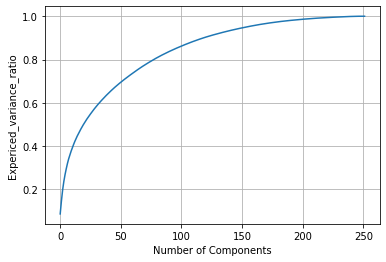

<Figure size 7200x7200 with 0 Axes>

In [ ]:
explained_variance = np.cumsum(pca_model_azdias.explained_variance_ratio_)
plt.plot(explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Expericed_variance_ratio')
plt.grid()
f = plt.figure()
f.set_figwidth(100)
f.set_figheight(100)
plt.show()

**So,from above plot, It can be observed that if I can take number of componets as 125 I tend to cover around 90% of the data**

In [ ]:
pca_model_azdias, tansformed_data_azdias = PCA_reduction(filtered_azdias_scalar,125)

**Elbow Curve**

60.63 sec 
112.78 sec 
155.10 sec 
208.50 sec 
260.16 sec 
309.02 sec 
339.35 sec 
418.46 sec 
541.99 sec 
559.90 sec 
561.12 sec 
647.63 sec 
629.95 sec 


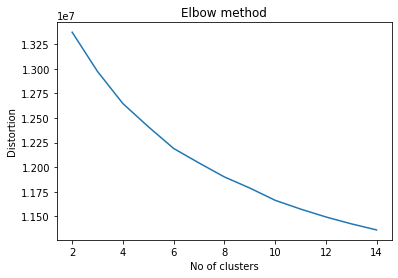

In [ ]:
data_points = np.array([])
for i in range(2,15):
    time_sec = time.time()
    
    k_means = KMeans(i)
    km_data = k_means.fit(tansformed_data_azdias)
    data_points = np.append(data_points, np.abs(km_data.score(tansformed_data_azdias)))
    print("{:.2f} sec ".format(time.time()-time_sec))

plt.plot(range(2,15),data_points)
plt.xlabel('No of clusters')
plt.ylabel('Distortion')
plt.title('Elbow method')
plt.show()

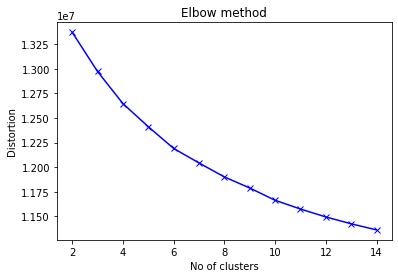

In [ ]:
plt.plot(range(2,15),data_points,'bx-')
plt.xlabel('No of clusters')
plt.ylabel('Distortion')
plt.title('Elbow method')
plt.show()

**For the given data, I conclude that the optimal number of clusters for the data is 9.**

In [ ]:
def kmeans(df):
    '''
    This function builds the final version of the KMeans model. 
    Args: 
    df: demographic dataframe
    returns: 
    k_means: kmeans model
    km_transformed_data: kmeans transformed data
    '''

    k_means = KMeans(9)
    km_transformed_data = k_means.fit_predict(df)
    return k_means,km_transformed_data


pca_model_customers, tansformed_data_customers = PCA_reduction(filtered_customers_scalar,125)

azdias_model,azdias_predict = kmeans(tansformed_data_azdias)
customers,customers_predict = kmeans(tansformed_data_customers)

In [ ]:
azdias_predict

array([4, 4, 1, ..., 4, 5, 1], dtype=int32)

In [ ]:
clusters_dataframe = pd.DataFrame({'Azdias': list(pd.Series(azdias_predict).value_counts().sort_index()), 'Customers': list(pd.Series(customers_predict).value_counts().sort_index())}, columns=['Azdias', 'Customers'])
azdias_count = clusters_dataframe['Azdias'].to_list()
clusters_dataframe['percentage_of_azdias'] = np.array([round(x/sum(azdias_count)*100,2) for x in azdias_count])
customers_count = clusters_dataframe['Customers'].to_list()
clusters_dataframe['percentage_of_customers'] = np.array([round(x/sum(customers_count)*100,2) for x in customers_count])
clusters_dataframe

,Azdias,Customers,percentage_of_azdias,percentage_of_customers
0,76869,20168,9.63,14.23
1,120887,18826,15.15,13.29
2,102229,15152,12.81,10.69
3,76923,12923,9.64,9.12
4,94314,20406,11.82,14.40
5,87984,19248,11.03,13.58
6,60601,14753,7.60,10.41
7,119164,14268,14.94,10.07
8,58865,5962,7.38,4.21


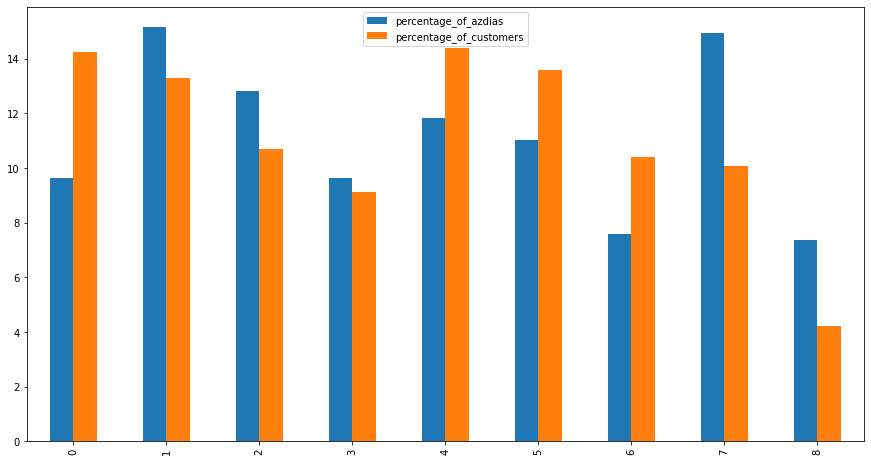

In [ ]:
clusters_dataframe[['percentage_of_azdias','percentage_of_customers']].plot(kind='bar',figsize=(15,8))

**I am intrested in clusters 0,4,5,6 where percentage of customers is higher than azdias which indirectly represents features for targetted audience. While 7,8 represent features which exclude core customers.**

In [ ]:
attr_desc.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [ ]:
a = dict(zip(filtered_customers_scalar.columns,pca_model_customers.inverse_transform(customers.cluster_centers_[4])))
df = pd.DataFrame.from_dict(a,orient='index')
df.columns = ['values']
df.sort_values(by='values',inplace=True)
df['Description_for_features'] = np.nan
for ix,row in attr_desc.iterrows():
    #print(row['Attribute'])
    df.loc[df.index == row['Attribute'],'Description_for_features'] = row['Description']
df.tail()

,values,Description_for_features
WOHNDAUER_2008,0.966706,length of residenca
OST_WEST_KZ,0.966770,flag indicating the former GDR/FRG
D19_VERSI_OFFLINE_DATUM,0.975777,actuality of the last transaction for the segm...
D19_TELKO_ONLINE_DATUM,0.994677,actuality of the last transaction for the segm...
D19_VERSI_ONLINE_DATUM,0.995075,actuality of the last transaction for the segm...


In [ ]:
a = dict(zip(filtered_customers_scalar.columns,pca_model_customers.inverse_transform(customers.cluster_centers_[5])))
df = pd.DataFrame.from_dict(a,orient='index')
df.columns = ['values']
df.sort_values(by='values',inplace=True)
df['Description_for_features'] = np.nan
for ix,row in attr_desc.iterrows():
    #print(row['Attribute'])
    df.loc[df.index == row['Attribute'],'Description_for_features'] = row['Description']
df.tail()

,values,Description_for_features
OST_WEST_KZ,0.988269,flag indicating the former GDR/FRG
D19_BANKEN_OFFLINE_DATUM,0.991501,actuality of the last transaction for the segm...
D19_VERSI_OFFLINE_DATUM,0.994988,actuality of the last transaction for the segm...
D19_TELKO_ONLINE_DATUM,0.998180,actuality of the last transaction for the segm...
D19_VERSI_ONLINE_DATUM,0.999482,actuality of the last transaction for the segm...


**Above script can be applied to other clusters to get their feature values with description**

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [4]:
mailout_train = None
zf = zipfile.ZipFile('/content/drive/MyDrive/Udacity_capstone/udacity_capstone_dataset.zip')
mailout_train = pd.read_csv(zf.open('Udacity_MAILOUT_052018_TRAIN.csv'), sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


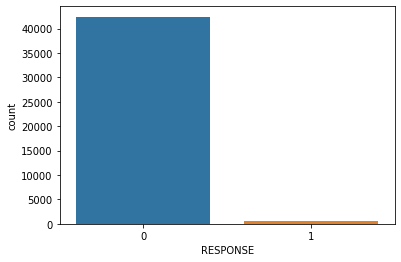

In [6]:
sns.countplot(x ='RESPONSE', data = mailout_train)

In [7]:
def mixed_type_format(df):
    '''This function is created for formating improper values in columns CAMEO_DEUG_2015 and CAMEO_INTL_2015.
    Args:
    df: demographics dataframe
    returns: transformed dataframe 
    '''
    
    cols_nan = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    for i in cols_nan:
        df[i] = df[i].replace({'X': np.nan, 'XX': np.nan})
    df[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].astype(float)

    return df

dict_unknown = {'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KBA05_GBZ': [-1, 0],
 'KBA05_HERST1': [-1, 9],
 'KBA05_HERST2': [-1, 9],
 'KBA05_HERST3': [-1, 9],
 'KBA05_HERST4': [-1, 9],
 'KBA05_HERST5': [-1, 9],
 'KBA05_HERSTTEMP': [-1, 9],
 'KBA05_KRSAQUOT': [-1, 9],
 'KBA05_KRSHERST1': [-1, 9],
 'KBA05_KRSHERST2': [-1, 9],
 'KBA05_KRSHERST3': [-1, 9],
 'KBA05_KRSKLEIN': [-1, 9],
 'KBA05_KRSOBER': [-1, 9],
 'KBA05_KRSVAN': [-1, 9],
 'KBA05_KRSZUL': [-1, 9],
 'KBA05_KW1': [-1, 9],
 'KBA05_KW2': [-1, 9],
 'KBA05_KW3': [-1, 9],
 'KBA05_MAXAH': [-1, 9],
 'KBA05_MAXBJ': [-1, 9],
 'KBA05_MAXHERST': [-1, 9],
 'KBA05_MAXSEG': [-1, 9],
 'KBA05_MAXVORB': [-1, 9],
 'KBA05_MOD1': [-1, 9],
 'KBA05_MOD2': [-1, 9],
 'KBA05_MOD3': [-1, 9],
 'KBA05_MOD4': [-1, 9],
 'KBA05_MOD8': [-1, 9],
 'KBA05_MODTEMP': [-1, 9],
 'KBA05_MOTOR': [-1, 9],
 'KBA05_MOTRAD': [-1, 9],
 'KBA05_SEG1': [-1, 9],
 'KBA05_SEG10': [-1, 9],
 'KBA05_SEG2': [-1, 9],
 'KBA05_SEG3': [-1, 9],
 'KBA05_SEG4': [-1, 9],
 'KBA05_SEG5': [-1, 9],
 'KBA05_SEG6': [-1, 9],
 'KBA05_SEG7': [-1, 9],
 'KBA05_SEG8': [-1, 9],
 'KBA05_SEG9': [-1, 9],
 'KBA05_VORB0': [-1, 9],
 'KBA05_VORB1': [-1, 9],
 'KBA05_VORB2': [-1, 9],
 'KBA05_ZUL1': [-1, 9],
 'KBA05_ZUL2': [-1, 9],
 'KBA05_ZUL3': [-1, 9],
 'KBA05_ZUL4': [-1, 9],
 'KBA13_ALTERHALTER_30': [-1],
 'KBA13_ALTERHALTER_45': [-1],
 'KBA13_ALTERHALTER_60': [-1],
 'KBA13_ALTERHALTER_61': [-1],
 'KBA13_AUDI': [-1],
 'KBA13_AUTOQUOTE': [-1],
 'KBA13_BJ_1999': [-1],
 'KBA13_BJ_2000': [-1],
 'KBA13_BJ_2004': [-1],
 'KBA13_BJ_2006': [-1],
 'KBA13_BJ_2008': [-1],
 'KBA13_BJ_2009': [-1],
 'KBA13_BMW': [-1],
 'KBA13_CCM_0_1400': [-1],
 'KBA13_CCM_1000': [-1],
 'KBA13_CCM_1200': [-1],
 'KBA13_CCM_1400': [-1],
 'KBA13_CCM_1400_2500': [-1],
 'KBA13_CCM_1500': [-1],
 'KBA13_CCM_1600': [-1],
 'KBA13_CCM_1800': [-1],
 'KBA13_CCM_2000': [-1],
 'KBA13_CCM_2500': [-1],
 'KBA13_CCM_2501': [-1],
 'KBA13_CCM_3000': [-1],
 'KBA13_CCM_3001': [-1],
 'KBA13_FAB_ASIEN': [-1],
 'KBA13_FAB_SONSTIGE': [-1],
 'KBA13_FIAT': [-1],
 'KBA13_FORD': [-1],
 'KBA13_HALTER_20': [-1],
 'KBA13_HALTER_25': [-1],
 'KBA13_HALTER_30': [-1],
 'KBA13_HALTER_35': [-1],
 'KBA13_HALTER_40': [-1],
 'KBA13_HALTER_45': [-1],
 'KBA13_HALTER_50': [-1],
 'KBA13_HALTER_55': [-1],
 'KBA13_HALTER_60': [-1],
 'KBA13_HALTER_65': [-1],
 'KBA13_HALTER_66': [-1],
 'KBA13_HERST_ASIEN': [-1],
 'KBA13_HERST_AUDI_VW': [-1],
 'KBA13_HERST_BMW_BENZ': [-1],
 'KBA13_HERST_EUROPA': [-1],
 'KBA13_HERST_FORD_OPEL': [-1],
 'KBA13_HERST_SONST': [-1],
 'KBA13_KMH_0_140': [-1],
 'KBA13_KMH_110': [-1],
 'KBA13_KMH_140': [-1],
 'KBA13_KMH_140_210': [-1],
 'KBA13_KMH_180': [-1],
 'KBA13_KMH_211': [-1],
 'KBA13_KMH_250': [-1],
 'KBA13_KMH_251': [-1],
 'KBA13_KRSAQUOT': [-1],
 'KBA13_KRSHERST_AUDI_VW': [-1],
 'KBA13_KRSHERST_BMW_BENZ': [-1],
 'KBA13_KRSHERST_FORD_OPEL': [-1],
 'KBA13_KRSSEG_KLEIN': [-1],
 'KBA13_KRSSEG_OBER': [-1],
 'KBA13_KRSSEG_VAN': [-1],
 'KBA13_KRSZUL_NEU': [-1],
 'KBA13_KW_0_60': [-1],
 'KBA13_KW_110': [-1],
 'KBA13_KW_120': [-1],
 'KBA13_KW_121': [-1],
 'KBA13_KW_30': [-1],
 'KBA13_KW_40': [-1],
 'KBA13_KW_50': [-1],
 'KBA13_KW_60': [-1],
 'KBA13_KW_61_120': [-1],
 'KBA13_KW_70': [-1],
 'KBA13_KW_80': [-1],
 'KBA13_KW_90': [-1],
 'KBA13_MAZDA': [-1],
 'KBA13_MERCEDES': [-1],
 'KBA13_MOTOR': [-1],
 'KBA13_NISSAN': [-1],
 'KBA13_OPEL': [-1],
 'KBA13_PEUGEOT': [-1],
 'KBA13_RENAULT': [-1],
 'KBA13_SEG_GELAENDEWAGEN': [-1],
 'KBA13_SEG_GROSSRAUMVANS': [-1],
 'KBA13_SEG_KLEINST': [-1],
 'KBA13_SEG_KLEINWAGEN': [-1],
 'KBA13_SEG_KOMPAKTKLASSE': [-1],
 'KBA13_SEG_MINIVANS': [-1],
 'KBA13_SEG_MINIWAGEN': [-1],
 'KBA13_SEG_MITTELKLASSE': [-1],
 'KBA13_SEG_OBEREMITTELKLASSE': [-1],
 'KBA13_SEG_OBERKLASSE': [-1],
 'KBA13_SEG_SONSTIGE': [-1],
 'KBA13_SEG_SPORTWAGEN': [-1],
 'KBA13_SEG_UTILITIES': [-1],
 'KBA13_SEG_VAN': [-1],
 'KBA13_SEG_WOHNMOBILE': [-1],
 'KBA13_SITZE_4': [-1],
 'KBA13_SITZE_5': [-1],
 'KBA13_SITZE_6': [-1],
 'KBA13_TOYOTA': [-1],
 'KBA13_VORB_0': [-1],
 'KBA13_VORB_1': [-1],
 'KBA13_VORB_1_2': [-1],
 'KBA13_VORB_2': [-1],
 'KBA13_VORB_3': [-1],
 'KBA13_VW': [-1],
 'KKK': [-1, 0],
 'NATIONALITAET_KZ': [-1, 0],
 'ORTSGR_KLS9': [-1],
 'OST_WEST_KZ': [-1],
 'PLZ8_ANTG1': [-1],
 'PLZ8_ANTG2': [-1],
 'PLZ8_ANTG3': [-1],
 'PLZ8_ANTG4': [-1],
 'PLZ8_GBZ': [-1],
 'PLZ8_HHZ': [-1],
 'PRAEGENDE_JUGENDJAHRE': [-1, 0],
 'REGIOTYP': [-1, 0],
 'RELAT_AB': [-1, 9],
 'RETOURTYP_BK_S': [0],
 'SEMIO_DOM': [-1, 9],
 'SEMIO_ERL': [-1, 9],
 'SEMIO_FAM': [-1, 9],
 'SEMIO_KAEM': [-1, 9],
 'SEMIO_KRIT': [-1, 9],
 'SEMIO_KULT': [-1, 9],
 'SEMIO_LUST': [-1, 9],
 'SEMIO_MAT': [-1, 9],
 'SEMIO_PFLICHT': [-1, 9],
 'SEMIO_RAT': [-1, 9],
 'SEMIO_REL': [-1, 9],
 'SEMIO_SOZ': [-1, 9],
 'SEMIO_TRADV': [-1, 9],
 'SEMIO_VERT': [-1, 9],
 'SHOPPER_TYP': [-1],
 'SOHO_FLAG': [-1],
 'TITEL_KZ': [-1, 0],
 'VERS_TYP': [-1],
 'WACHSTUMSGEBIET_NB': [-1, 0],
 'WOHNDAUER_2008': [-1, 0],
 'WOHNLAGE': [-1],
 'W_KEIT_KIND_HH': [-1, 0],
 'ZABEOTYP': [-1, 9]}





In [8]:
def replace_unknown_with_nan(df, dict_unknown):
    '''This method accepts a dataframe which is going to check for the missing values by using column name and dictionary,
    if any such exists it will be replace by np.nan. And the procedure for retrieving the particular column positions is already
    explained in the above cell using loc function
    Args:
    df: demographics dataframe
    dict_unknown: dictionary which contains encodings for unknown values for each column of the dataset
    returns: filtered df
    '''
    for key, value in dict_unknown.items():
        if key in df.columns:
            for i in range(0, len(value)):
                #print(key,value)
                df.loc[df[key] == value[i], key] = np.nan
    return df


def remove_outliers(df,sub_part_df):
    Q1 = sub_part_df.quantile(0.25)
    Q3 = sub_part_df.quantile(0.75)
    IQR = Q3-Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    df = df[~((sub_part_df < lower_limit) | (sub_part_df > upper_limit)).any(axis=1)]


def get_missing_data_rows_columns(df):
    missing_col_df = pd.Series(df.isnull().sum(),name='count').to_frame()
    percentage_list = missing_col_df['count'].to_list()
    percentage_list = [round((x/df.shape[0])*100,2) for x in percentage_list]
    missing_col_df['percentage'] = percentage_list
    missing_rows_df = pd.Series(df.isnull().sum(axis=1)[df.isnull().sum(axis=1) > int(0.5*369)],name="count").to_frame()
    percentage_row_list = missing_rows_df['count'].to_list()
    percentage_row_list = [round((x/df.shape[1])*100,2) for x in percentage_row_list]
    missing_rows_df['percentage'] = percentage_row_list
    return missing_col_df,missing_rows_df



def cols_to_drop_corr(df):
    correlation_matrix = df.corr().abs().round(2)

    #selet upper traingle
    upper_traingle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(np.bool))

    cols_to_drop = []

    
    for col in upper_traingle.columns:
        if any(upper_traingle[col]>0.90):
            cols_to_drop.append(col)

    return cols_to_drop


def min_max_scalar(df):
    scale = MinMaxScaler()
    return pd.DataFrame(scale.fit_transform(df), columns=df.columns)

**DATA PREPROCESSING**

Applying all the methods that have been metioned above

In [9]:
train = mailout_train.copy()

In [10]:
def preprocess_data(df,mailout_train):
    ''' This function preprocess both mailout_train and mailout_test to get dataset ready for suervised models
    Args: 
    df: demographic dataframe
    returns: preprocessed dataset
    '''

    #Format mixed-types
    df = mixed_type_format(df)
    #Replace unknowns
    df = replace_unknown_with_nan(df, dict_unknown)
    unknown_addnt_values = {'KBA05_MODTEMP': [6.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0],'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'ORTSGR_KLS9': [0.0], 'GEBURTSJAHR': [0]}
    df = replace_unknown_with_nan(df,unknown_addnt_values)
    #Remove Outliers
    sub_part_df_cols_list = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL', 'KBA13_ANZAHL_PKW']
    remove_outliers(df, df[sub_part_df_cols_list])
    missing_cols_mailout,missing_rows_mailout = get_missing_data_rows_columns(df)

    #Removing columns with missing data
    columns_to_drop = list(missing_cols_mailout.index[missing_cols_mailout['percentage'] > 30])
    df = df.drop(columns=columns_to_drop,axis=1)

    cols_to_drop = None
    cols_to_drop = cols_to_drop_corr(df)
    
    cols = ['D19_GESAMT_ANZ_24','D19_VERSAND_OFFLINE_DATUM']
    for col in cols:
        if col in cols_to_drop:
            cols_to_drop.remove(col)
    
    df = df.drop(cols_to_drop,axis=1)
    feature_engeering(df)
    
    columns_not = [col for col in df.columns if col not in mailout_train.columns]
    
    
    print('Columns not present in mailout_train: ', columns_not)
    columns_not_train = [col for col in mailout_train.columns if col not in df.columns]
    print('Columns not present in mailout_test: ', columns_not_train)
    
    df = min_max_scalar(df)
    
    return df

In [11]:
mailout_train = preprocess_data(mailout_train,train)

Replaced ANZ_HAUSHALTE_AKTIV
Replaced KBA13_ANZAHL_PKW
created PRAEGENDE_JUGENDJAHRE_movement
created PRAEGENDE_JUGENDJAHRE_decade
LNR
Imputed LNR
AKT_DAT_KL
Imputed AKT_DAT_KL
ALTERSKATEGORIE_FEIN
Imputed ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
Imputed ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
Imputed ANZ_HH_TITEL
ANZ_KINDER
Imputed ANZ_KINDER
ANZ_PERSONEN
Imputed ANZ_PERSONEN
ANZ_TITEL
Imputed ANZ_TITEL
ARBEIT
Imputed ARBEIT
BALLRAUM
Imputed BALLRAUM
Imputed CAMEO_DEU_2015
CAMEO_DEUG_2015
Imputed CAMEO_DEUG_2015
CJT_GESAMTTYP
Imputed CJT_GESAMTTYP
CJT_KATALOGNUTZER
Imputed CJT_KATALOGNUTZER
CJT_TYP_1
Imputed CJT_TYP_1
CJT_TYP_2
Imputed CJT_TYP_2
CJT_TYP_3
Imputed CJT_TYP_3
CJT_TYP_4
Imputed CJT_TYP_4
CJT_TYP_5
Imputed CJT_TYP_5
CJT_TYP_6
Imputed CJT_TYP_6
D19_BANKEN_ANZ_12
Imputed D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
Imputed D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
Imputed D19_BANKEN_DATUM
D19_BANKEN_DIREKT
Imputed D19_BANKEN_DIREKT
D19_BANKEN_GROSS
Imputed D19_BANKEN_GROSS
D19_BANKEN_LOKAL
Imputed

In [12]:
train_y = mailout_train[['RESPONSE']]
train_x = mailout_train.drop(['RESPONSE', 'LNR'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34369 entries, 39864 to 1612
Columns: 334 entries, AKT_DAT_KL to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(334)
memory usage: 87.8 MB


**2.2 Evaluation Metrics**

Since majority of the outcome of the dataset is 0, indicating very high imbalanced data traditional accuracy metrics or score does not work properly. Whatever might be the input the accuracy surely goint to be more than 95%. To avoid such misleadings, the evaluation metrics used here will be ROC-AUC which handles true positive rate and the false positive rate efficiently

**2.3 Model Implementation**

Here, I want to try out varios in-built classification models already available in sckit-learn and choose that which gives me highest accuracy among others

First I want to give a try with Logistic regression before moving to advanced ML classifiers

In [30]:
clf = LogisticRegression(max_iter=100,random_state=42).fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [31]:
print("Accuracy with traditional approach using Logistic Regression {:.2f}".format(clf.score(X_test,y_test)))

y_pred = clf.predict_proba(X_test)[:,1]
print("Accuracy with ROC_AUC metrics approach using Logistic Regression {:.2f}".format(roc_auc_score(y_test,y_pred)))

Accuracy with traditional approach using Logistic Regression 0.99
Accuracy with ROC_AUC metrics approach using Logistic Regression 0.64


In [ ]:
def build_model(model,X_train,X_test,y_train,y_test):
    ''' This function returns he ROC_AUC score various classifiers
    '''
    model = model.fit(X_train,y_train.values.ravel())
    y_pred = model.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test,y_pred)

classifiers = {
    "XGBClassifier":xgb.XGBClassifier(random_state=42),"Nearest Neighbors":KNeighborsClassifier(3),"Random Forest":RandomForestClassifier(random_state=42),
    "AdaBoost":AdaBoostClassifier(random_state=42),"GradientBoostingClassifier":GradientBoostingClassifier(random_state=42)}

for algo_name,classifier in classifiers.items():
    print(" ROC_AUC score for {} is {:.2f}".format(algo_name,build_model(classifier,X_train,X_test,y_train,y_test)))

 ROC_AUC score for XGBClassifier is 0.74
 ROC_AUC score for Nearest Neighbors is 0.50
 ROC_AUC score for Random Forest is 0.60
 ROC_AUC score for AdaBoost is 0.73
 ROC_AUC score for GradientBoostingClassifier is 0.73


**RandomForest and Nearest Neighbours can easily be ruled out from the list**

**Well after receiving an roc_auc score of 0.74 by XGBClassifer and 0.73 with AdaBoost and GradientBoostingClassifier I had directly applied this to test data and uploaded to kagle competiotions but kagggle score was around 0.45**

**With, the help of GridSearchCv I tried to tune AdaBoost and GradientBoostingClassifier and XGBClassifier**

In [27]:
def plot_learning_curve(X,y,estimator,training_num):
    train_size, train_score, test_score = learning_curve(estimator, X, y, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, training_num))
    train_mean,test_mean = np.mean(train_score,axis=1),np.mean(test_score,axis=1)
    print("AUC_ROC train score = {}".format(train_mean[-1].round(2)))
    print("AUC_ROC validation score = {}".format(test_mean[-1].round(2)))
    plt.xlabel("training set %")
    plt.ylabel("Learning curves")
    plt.grid()
    plt.title("Learning curves")
    plt.plot(np.linspace(.1, 1.0, training_num)*100, train_mean, 'o-', color="r",label="Training score")
    plt.plot(np.linspace(.1, 1.0, training_num)*100, test_mean, 'o-', color="b",label="Cross-validation score")
    a = np.arange(0., 100.05, 10)
    b = np.arange(0.45, 1.02, 0.05)
    plt.xticks(a)
    plt.yticks(b)
    plt.legend(loc="best")
    plt.show()

**Learning Curve for XGBOOST Classifier**

AUC_ROC train score = 0.89
AUC_ROC validation score = 0.76


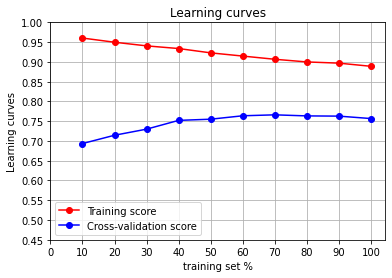

In [28]:
pipeline = Pipeline([('model', xgb.XGBClassifier(random_state=42))])
plot_learning_curve(train_x,train_y.values.ravel(),pipeline,10)

**Learning Curve for AdaBoost Classifier**

AUC_ROC train score = 0.84
AUC_ROC validation score = 0.73


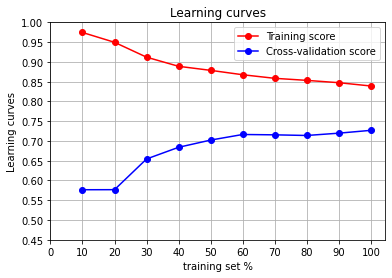

In [29]:
pipeline = Pipeline([('model', AdaBoostClassifier(random_state=42))])
plot_learning_curve(train_x,train_y.values.ravel(),pipeline,10)

AUC_ROC train score = 0.91
AUC_ROC validation score = 0.75


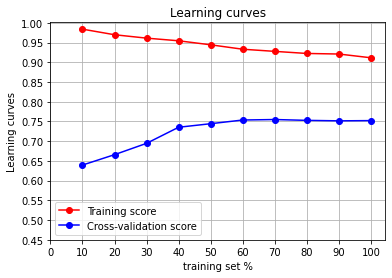

In [30]:
pipeline = Pipeline([('model', GradientBoostingClassifier(random_state=42))])
plot_learning_curve(train_x,train_y.values.ravel(),pipeline,10)

In [15]:
from sklearn.model_selection import GridSearchCV
params = {
     'n_estimators': np.arange(25,200,25),
     'learning_rate': [0.01, 0.05, 0.1, 1],
 }
grid_cv = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid= params, cv=5, n_jobs=-1,scoring = "roc_auc")

In [16]:
%time grid_cv.fit(X_train,y_train.values.ravel())

CPU times: user 23.5 s, sys: 1.53 s, total: 25 s
Wall time: 33min 59s


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 1],
                         'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [17]:
grid_cv.best_score_,grid_cv.best_params_

(0.7603690617450454, {'learning_rate': 0.01, 'n_estimators': 50})

In [18]:
grid_cv.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=50, random_state=42)

In [19]:
pred_ada = grid_cv.best_estimator_.predict_proba(X_test)[:,1]
roc_auc_score(y_test,pred_ada)

0.7528635346756153

In [35]:
pred_all = grid_cv.best_estimator_.predict_proba(train_x)[:,1]
roc_auc_score(train_y,pred_all)

0.7588457282140068

In [33]:
model_xgb = xgb.XGBClassifier(eta= 0.05, max_depth= 5, min_child_weight= 10, n_estimators= 300) # best_estimators tuned after getting GridcvSearch in another instance
model_xgb = model_xgb.fit(X_train,y_train.values.ravel())
y_pred = model_xgb.predict_proba(X_test)[:,1]
roc_auc_score(y_test,y_pred)

0.7242246555987284

**The roc_auc score for xgb is lower than other two so it can be ruled out**

**I want to give a try with GradientBoostingClassifier using pipeling technique**

In [20]:
complete_pred_ada = grid_cv.best_estimator_.predict_proba(train_x)[:,1]
roc_auc_score(train_y,complete_pred_ada)

0.7588457282140068

In [59]:
gbc_pipeline_gd = Pipeline([
    ('gbc', GradientBoostingClassifier(random_state=42))
])
parameters = {'gbc__learning_rate': [0.1, 0.2], 'gbc__n_estimators': [100],'gbc__max_depth': [3, 5], 'gbc__min_samples_split': [2,4]}
grid_obj = GridSearchCV(gbc_pipeline_gd, parameters, scoring = 'roc_auc', verbose=50)
grid_obj.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100, score=0.775, total=  39.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.0s remaining:    0.0s
[CV] gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100, score=0.712, total=  40.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s
[CV] gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100 
[CV]  gbc__learning_rate=0.1, gbc__max_depth=3, gbc__min_samples_split=2, gbc__n_estimators=100, score=0.775, total=  40.3s
[Parallel(n_jobs=1)]: Done   3 out of  

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('gbc',
                                        GradientBoostingClassifier(ccp_alpha=0.0,
                                                                   criterion='friedman_mse',
                                                                   init=None,
                                                                   learning_rate=0.1,
                                                                   loss='deviance',
                                                                   max_depth=3,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
      

In [61]:
grid_obj.best_params_

{'gbc__learning_rate': 0.1,
 'gbc__max_depth': 3,
 'gbc__min_samples_split': 2,
 'gbc__n_estimators': 100}

In [63]:
y_pred = grid_obj.best_estimator_.predict_proba(X_test)[:,1]
print("ROC_AUC score for GBC pipeline {:.5f} ".format(roc_auc_score(y_test,y_pred)))

ROC_AUC score for GBC pipeline 0.73626 


In [65]:
complete_pred = grid_obj.best_estimator_.predict_proba(train_x)[:,1]
roc_auc_score(train_y,complete_pred)

0.8725006600876455

**Well GradientBoosting dominated AdaBoost in terms of overall prediction but for test data AdaBoost out traced GradientBoostingClassifier. Since, this is a competition I have send both the submissions to kaggle GradientBoostingClassifier score was around 0.57 while AdaBoost score was around 0.78. GradientBoosting migh have overfitted with the data leading to score on MailOut test data**

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [39]:
mailout_test = pd.read_csv(zf.open('Udacity_MAILOUT_052018_TEST.csv'), sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Pre-process the data as done for training set**

In [40]:
maiout_test_lnr = mailout_test["LNR"]

In [41]:
test = mailout_test.copy()
mailout_test = preprocess_data(mailout_test,mailout_train)

Replaced ANZ_HAUSHALTE_AKTIV
Replaced KBA13_ANZAHL_PKW
created PRAEGENDE_JUGENDJAHRE_movement
created PRAEGENDE_JUGENDJAHRE_decade
LNR
Imputed LNR
AKT_DAT_KL
Imputed AKT_DAT_KL
ALTERSKATEGORIE_FEIN
Imputed ALTERSKATEGORIE_FEIN
ANZ_HAUSHALTE_AKTIV
Imputed ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
Imputed ANZ_HH_TITEL
ANZ_KINDER
Imputed ANZ_KINDER
ANZ_PERSONEN
Imputed ANZ_PERSONEN
ANZ_TITEL
Imputed ANZ_TITEL
ARBEIT
Imputed ARBEIT
BALLRAUM
Imputed BALLRAUM
Imputed CAMEO_DEU_2015
CAMEO_DEUG_2015
Imputed CAMEO_DEUG_2015
CJT_GESAMTTYP
Imputed CJT_GESAMTTYP
CJT_KATALOGNUTZER
Imputed CJT_KATALOGNUTZER
CJT_TYP_1
Imputed CJT_TYP_1
CJT_TYP_2
Imputed CJT_TYP_2
CJT_TYP_3
Imputed CJT_TYP_3
CJT_TYP_4
Imputed CJT_TYP_4
CJT_TYP_5
Imputed CJT_TYP_5
CJT_TYP_6
Imputed CJT_TYP_6
D19_BANKEN_ANZ_12
Imputed D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
Imputed D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
Imputed D19_BANKEN_DATUM
D19_BANKEN_DIREKT
Imputed D19_BANKEN_DIREKT
D19_BANKEN_GROSS
Imputed D19_BANKEN_GROSS
D19_BANKEN_LOKAL
Imputed

In [43]:
mailout_test=mailout_test.drop(['LNR'],axis=1)
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 334 entries, AKT_DAT_KL to PRAEGENDE_JUGENDJAHRE_decade
dtypes: float64(334)
memory usage: 109.1 MB


In [48]:
model_best = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,n_estimators=50, random_state=42)
model_best = model_best.fit(train_x,train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
y_pred = grid_cv.best_estimator_.predict_proba(mailout_test)[:,1]
y_pred

array([0.0407627 , 0.0407627 , 0.02660109, ..., 0.0407627 , 0.03722515,
       0.0407627 ])

In [51]:
model_best.feature_importances_

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.22, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.78, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [54]:
model_best = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,n_estimators=50, random_state=42)
model_best.fit(train_x,train_y.values.ravel())

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=50, random_state=42)

In [47]:
solution_1 = pd.DataFrame(index = maiout_test_lnr,data=y_pred,columns=['RESPONSE'])
solution_1

,RESPONSE
LNR,
1754,0.040763
1770,0.040763
1465,0.026601
1470,0.026601
1478,0.029160
...,...
67615,0.037225
67938,0.012892
67942,0.040763


In [57]:
solution_1.to_csv('kaggle_submission.csv')